## 1. Building ENM 

In [14]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from prody import *
from pylab import *
import Bio.PDB
from scipy.stats import pearsonr
from scipy.spatial import distance
from MDAnalysis.analysis import distances
from scipy.linalg import fractional_matrix_power
from scipy.optimize import minimize
from numpy import diff
import pandas as pd

In [15]:
file_dir = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/"
pdb = file_dir+"confout_1.gro"
u = mda.Universe(pdb, pdb)
CA = u.select_atoms('name CA')
n_res = CA.n_residues
spring_constant = 1
temperature = 310
RT = temperature*8.314/1000

In [16]:
def get_positions(CA):
    positions = CA.positions/10 # In nano meters
    distance_map = distance.cdist(positions, positions)
    distance_map = np.repeat(np.repeat(distance_map, 3, axis=1), 3, axis=0)
    inv_distsq_map = distance_map**-2
    inv_distsq_map[inv_distsq_map == np.inf] = 0
    return positions, distance_map, inv_distsq_map

def get_kirchoff_matrix(distance_map, n_res, cutoff, spring_constant):
    kirchoff_matrix = np.ones((n_res*3, n_res*3))
    kirchoff_matrix[distance_map>cutoff] = 0
    kirchoff_matrix = spring_constant*kirchoff_matrix
    return kirchoff_matrix

def get_hessian(positions, kirchoff_matrix, inv_distsq_map, n_res):
    xx_distance_map = distance.cdist(positions[:, 0].reshape(-1, 1), positions[:, 0].reshape(-1, 1), lambda u, v: u-v)
    yy_distance_map = distance.cdist(positions[:, 1].reshape(-1, 1), positions[:, 1].reshape(-1, 1), lambda u, v: u-v)
    zz_distance_map = distance.cdist(positions[:, 2].reshape(-1, 1), positions[:, 2].reshape(-1, 1), lambda u, v: u-v)

    H = np.zeros((n_res*3, n_res*3))
    H[0::3, 0::3] = xx_distance_map * xx_distance_map
    H[1::3, 1::3] = yy_distance_map * yy_distance_map
    H[2::3, 2::3] = zz_distance_map * zz_distance_map
    H[0::3, 1::3] = xx_distance_map * yy_distance_map
    H[0::3, 2::3] = xx_distance_map * zz_distance_map
    H[1::3, 2::3] = yy_distance_map * zz_distance_map
    H[1::3, 0::3] = xx_distance_map * yy_distance_map
    H[2::3, 0::3] = xx_distance_map * zz_distance_map
    H[2::3, 1::3] = yy_distance_map * zz_distance_map
    H = -1 * kirchoff_matrix * inv_distsq_map * H

    for i in range(n_res):
        H[i*3+0, i*3+0] = -1*np.sum(H[i*3+0, 0::3])
        H[i*3+1, i*3+1] = -1*np.sum(H[i*3+1, 1::3])
        H[i*3+2, i*3+2] = -1*np.sum(H[i*3+2, 2::3])
        H[i*3+0, i*3+1] = -1*np.sum(H[i*3+0, 1::3])
        H[i*3+1, i*3+0] = H[i*3+0, i*3+1]
        H[i*3+0, i*3+2] = -1*np.sum(H[i*3+0, 2::3])
        H[i*3+2, i*3+0] = H[i*3+0, i*3+2]
        H[i*3+1, i*3+2] = -1*np.sum(H[i*3+1, 2::3])
        H[i*3+2, i*3+1] = H[i*3+1, i*3+2]  
    return H

def get_mass_matrix(CA):
    residue_mass = CA.residues.masses/1000
    residue_mass = np.repeat(residue_mass, 3)
    M = np.diag(residue_mass)
    M_f = fractional_matrix_power(M, -0.5)
    return M_f

def get_mass_weighted_H(M_f, H):
    H_m = (M_f@H)@M_f
    return H_m

def get_fluctuations(M_f, H_m, RT):
    [v, U_m] = np.linalg.eig(H_m)
    U_m = U_m[:, np.argsort(v)]
    v = v[np.argsort(v)]
    U_m = U_m.astype('float64')
    M_f = M_f.astype('float64')
    v = v.astype('float64')
    m = len(H_m[0])
    C = np.zeros((np.shape(H_m)))
    for i in range(len(v)-6):
        C += (np.outer((M_f@U_m[:, i+6]), U_m[:, i+6].T)@M_f)/v[i+6]
    C = RT*C
    sq_fluctuations = np.diag(C).reshape(-1,3).sum(axis=1)
    F = np.sqrt(sq_fluctuations)
    return sq_fluctuations, F

In [17]:
positions, distance_map, inv_distsq_map = get_positions(CA)
M_f = get_mass_matrix(CA)
def fluctuations(CA, n_res, cutoff, spring_constant):
    kirchoff_matrix = get_kirchoff_matrix(distance_map, n_res, cutoff, spring_constant)
    H = get_hessian(positions, kirchoff_matrix, inv_distsq_map, n_res)
    H_m = get_mass_weighted_H(M_f, H)
    sq_fluctuations, F = get_fluctuations(M_f, H_m, RT)
    return sq_fluctuations, F

/var/tmp/pbs.3547524.pbshpc/ipykernel_22051/2539767524.py:5: RuntimeWarning: divide by zero encountered in power
  inv_distsq_map = distance_map**-2


In [18]:
rmsf_L = np.genfromtxt(file_dir+'rmsf_chL.xvg', skip_header=17)[:, 1]
rmsf_H = np.genfromtxt(file_dir+'rmsf_chH.xvg', skip_header=17)[:, 1]
rmsf = np.hstack((rmsf_L, rmsf_H))*10

In [ ]:
cutoff = range(10, 20)
pearson_corr = []
for Rc in cutoff:
    sq_fluctuations_P, F_P = fluctuations(CA, n_res, Rc/10, spring_constant)
    corr, _ = pearsonr(rmsf, F_P)
    pearson_corr.append(corr)

In [ ]:
pearson_corr

In [ ]:
# With my 1ns rmsf
index = pearson_corr.index(max(pearson_corr))
opt_Rc = cutoff[index]/10
print('Maximum pearson coefficient is', max(pearson_corr), 'at: ', opt_Rc, 'nanoseconds')
ax = plt.subplot()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(cutoff, pearson_corr, marker='o', linestyle='--', color = 'black', linewidth = 0.9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim(0, 0.8)
plt.title("S1: Maximum pearson coefficient is 0.6237945086588266 at:  1.1 nanoseconds")
plt.xlabel("cutoff (A)", fontsize = 10)
plt.ylabel("Pearson Coefficient", fontsize = 10)

In [ ]:
sq_fluctuations, F = fluctuations(CA, n_res, opt_Rc, spring_constant)
plt.plot(F, label = "With model", color = 'red', linewidth=0.8)
plt.plot(rmsf, label = "MD simulations", color = 'black', alpha=0.8, linewidth=0.8)
plt.legend(frameon = False, prop={'size':8})
#plt.title("Comparing fluctuations: ENM vs MD simulation")
plt.xlabel("modes", fontsize = 10)
plt.ylabel("Sq fluctuations (A2)", fontsize = 10)

In [ ]:
scale = (sq_fluctuations.mean()/rmsf.mean()**2)
print('The scale (kJ/A^2)is:', scale)

In [ ]:
spring_constant = spring_constant*scale
sq_fluctuations_scale, F_scale = fluctuations(CA, n_res, opt_Rc, spring_constant)

In [ ]:
ax = plt.subplot()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(F_scale, label = "With model", color = 'red', linewidth=0.9)
ax.plot(rmsf, label = "MD simulations", color = 'black', alpha=0.8, linewidth=0.9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon = False, prop={'size':8})
#plt.title("Comparing fluctuations: ENM vs MD simulation")
plt.xlabel("modes", fontsize = 10)
plt.ylabel("Sq fluctuations (A2)", fontsize = 10)

In [ ]:
fig,axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 6), layout='constrained')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

axes[1].plot(F, label = "With model", color = 'red', linewidth=0.8)
axes[1].plot(rmsf, label = "MD simulations", color = 'black', alpha=0.8, linewidth=0.8)
axes[1].legend(frameon = False, prop={'size':8})
axes[1].set_xlabel("modes", fontsize = 8)
axes[1].set_ylabel("Sq fluctuations (A2)", fontsize = 8)
axes[1].text(-50, 2.9, "B", fontsize = 12)
axes[0].plot(cutoff, pearson_corr, marker='o', linestyle='--', color = 'black', linewidth = 0.9)
axes[0].set_ylim(0, 0.8)
axes[0].text(8, 0.75, "A", fontsize = 12)
axes[0].set_xlabel("cutoff (A)", fontsize = 8)
axes[0].set_ylabel("Pearson Coefficient", fontsize = 8)
axes[2].plot(F_scale, label = "With model", color = 'red', linewidth=0.9)
axes[2].plot(rmsf, label = "MD simulations", color = 'black', alpha=0.8, linewidth=0.9)
axes[2].legend(frameon = False, prop={'size':8})
axes[2].set_xlabel("modes", fontsize = 8)
axes[2].set_ylabel("Sq fluctuations (A2)", fontsize = 8)
axes[2].text(-50, 2, "C", fontsize = 12)

## 2. Direction of change 

In [12]:
cutoff = opt_Rc
positions, distance_map, inv_distsq_map = get_positions(CA)
M_f = get_mass_matrix(CA)
kirchoff_matrix = get_kirchoff_matrix(distance_map, n_res, cutoff, spring_constant)
H = get_hessian(positions, kirchoff_matrix, inv_distsq_map, n_res)
H_m = get_mass_weighted_H(M_f, H)
[v, U_m] = np.linalg.eig(H_m)
arr_v = v
U_m = U_m[:, np.argsort(v)]
v = v[np.argsort(v)]  #eigenvalue
U = M_f @ U_m  #eigenvector

/var/tmp/pbs.3539253.pbshpc/ipykernel_9296/2539767524.py:5: RuntimeWarning: divide by zero encountered in power
  inv_distsq_map = distance_map**-2


#### Excitation along normal modes

In [13]:
box = file_dir+"box.pdb"
pdb = file_dir+"pdb_ref.pdb"
x = mda.Universe(pdb, pdb)
antibody = x.select_atoms('chainID A or chainID B')
Um = U_m[6:26]
m = len(Um)

def excite(Um, box, delT, cycle):
    v_extra = np.zeros(Um[0].shape)
    v_extra = Um[cycle]
    v_extra = v_extra/ np.linalg.norm(v_extra)
    
    M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
    np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

    v_excite = np.zeros(antibody.n_atoms*3)
    for i in range(antibody.n_residues):
        for j in antibody.residues[i].atoms.indices:
            v_excite[3*j] = v_extra[3*i]
            v_excite[3*j+1] = v_extra[3*i+1]
            v_excite[3*j+2] =  v_extra[3*i+2]
    u = mda.Universe(box,box)
    alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2)
    lmda = (alpha * delT)**0.5
    v_extra = 0.316 *lmda * v_extra # Convert to Angs/ps
    return v_extra.reshape(-1,3)

In [14]:
def save_gro(Um, v_extra, gro_in, delT, cycle):
    gro = mda.Universe(gro_in)
    frame = gro.trajectory[-1]
    for i in range(antibody.n_residues):
        for j in gro.residues[i].atoms.indices:
            frame.velocities[j] += v_extra[i]
    filename = file_dir+'{}_delT/{}_mode/md.gro'.format(delT, cycle)
    print(f"Writing new GRO file to {filename}")
    gro.atoms.write(filename, reindex=False)

In [15]:
gro_in = file_dir+"confout.gro"
delT = [75, 100]
for i in delT:
    for j in range(20):
        v_extra = excite(Um, box, i, j)
        save_gro(Um, v_extra, gro_in, i, j)

Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/75_delT/0_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/75_delT/1_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/75_delT/2_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/75_delT/3_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/75_delT/4_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/75_delT/5_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/75_delT/6_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/75_delT/7_mode

#### RMSD Projections and plots

In [13]:
from MDAnalysis.analysis import align
import sys

box = file_dir+"box.pdb"
pdb = file_dir+"pdb_ref.pdb"
x = mda.Universe(pdb, pdb)
antibody = x.select_atoms('chainID A or chainID B')
Um = U_m[6:26]
m = len(Um)

def excite(Um, box, delT, cycle):
    v_extra = np.zeros(U_m.shape[0])
    v_extra = Um[cycle]
    v_extra = v_extra/np.linalg.norm(v_extra)
    u = mda.Universe(box, box)
    M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
    np.fill_diagonal(M_exite, (antibody.atoms.masses.repeat(3)/1000) ** 0.5)

    v_excite = np.zeros(antibody.n_atoms*3)
    for i in range(antibody.n_residues):
        for j in antibody.residues[i].atoms.indices:
            v_excite[3*j] = v_extra[3*i]
            v_excite[3*j+1] = v_extra[3*i+1]
            v_excite[3*j+2] =  v_extra[3*i+2]
    
    alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2)
    lmda = (alpha * delT)**0.5
    v_extra = 0.316 *lmda * v_extra # Convert to Angs/ps
    return v_extra

def residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, selection, Um, cycle, delT):
    u = mda.Universe(pdb_mdenm, xtc_mdenm)
    v = mda.Universe(pdb_ref, pdb_ref)
    v_lrt = excite(Um, box, delT, cycle)
    v_lrt = v_lrt/np.linalg.norm(v_lrt) 
    u_fvca = u.select_atoms(selection)
    v_fvca = v.select_atoms(selection)
    dp = []
    for _ in u.trajectory:
        _ = align.alignto(u_fvca, v_fvca)
        deformation = (u_fvca.positions - v_fvca.positions).flatten()
        dp.append((np.dot(deformation, v_lrt)**2/u_fvca.n_residues)**0.5)
    return np.array(dp)

In [14]:
# For delT = 75
delT = 75
rd_75 = []
time = [i*10 for i in range(101)]
for i in range(20):
    pdb_mdenm = file_dir+"75_delT/{}_mode/pdb_mdenm.pdb".format(i)
    xtc_mdenm = file_dir+"75_delT/{}_mode/xtc_mdenm.xtc".format(i)    
    pdb_ref = file_dir+"pdb_ref.pdb"
    z_v = [residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, '(chainID A or chainID B) and name CA', Um, i, delT)]
    z_v = z_v[0]
    z_v = [i*0.1 for i in (z_v)]
    rd_75.append(z_v)
#     plt.figure(figsize=(8,6))
#     plt.rcParams['font.size'] = '16'
#     plt.plot(time, z_v, '*')
#     plt.title('delT = 75 K')
#     plt.xlabel('Time (ps)')
#     plt.ylabel('RMSD-v_extra (nm)')
#     plt.legend([str(i) for j in range(20)])
#     plt.legend([str(i)])

In [15]:
# For delT = 100
delT = 100
rd_100 = []
time = [i*10 for i in range(101)]
for i in range(20):
    pdb_mdenm = file_dir+"100_delT/{}_mode/pdb_mdenm.pdb".format(i)
    xtc_mdenm = file_dir+"100_delT/{}_mode/xtc_mdenm.xtc".format(i)
    pdb_ref = file_dir+"pdb_ref.pdb"
    z_v = [residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, '(chainID A or chainID B) and name CA', Um, i, delT)]
    z_v = z_v[0]
    z_v = [i*0.1 for i in (z_v)]
    rd_100.append(z_v)
#     plt.figure(figsize=(8,6))
#     plt.rcParams['font.size'] = '16'
#     plt.plot(time, z_v, '*')
#     plt.title('delT = 100 K')
#     plt.xlabel('Time (ps)')
#     plt.ylabel('RMSD-v_extra (nm)')
# #    plt.legend([str(i) for j in range(20)])
#     plt.legend([str(i)])

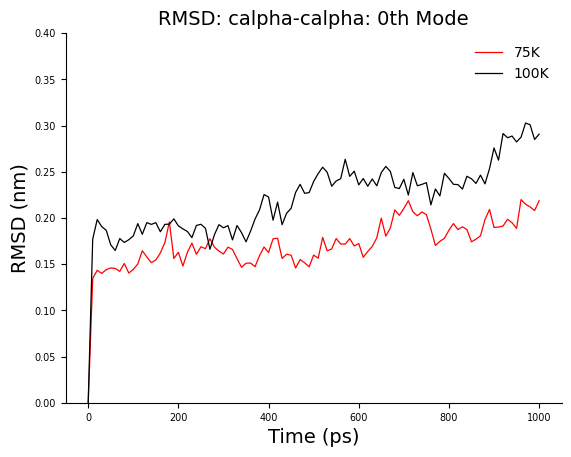

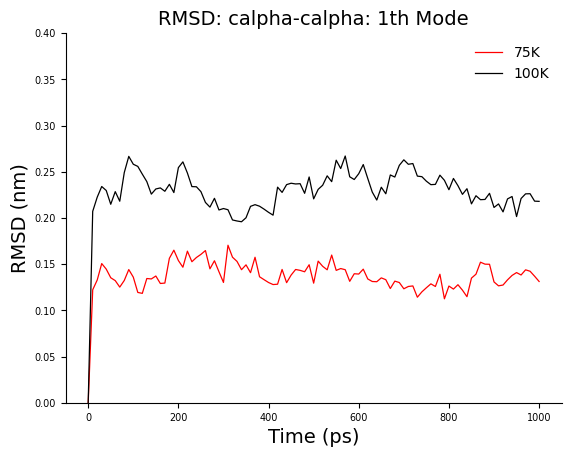

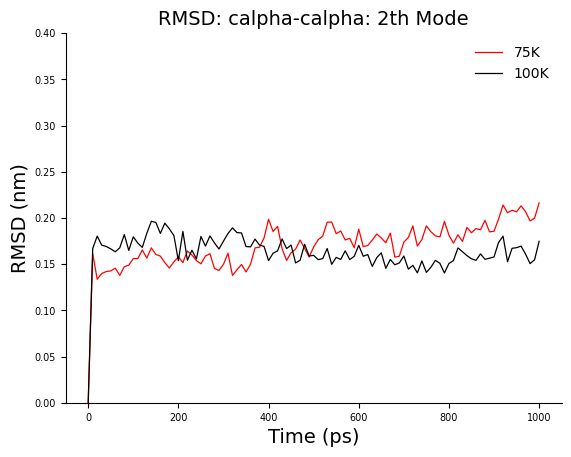

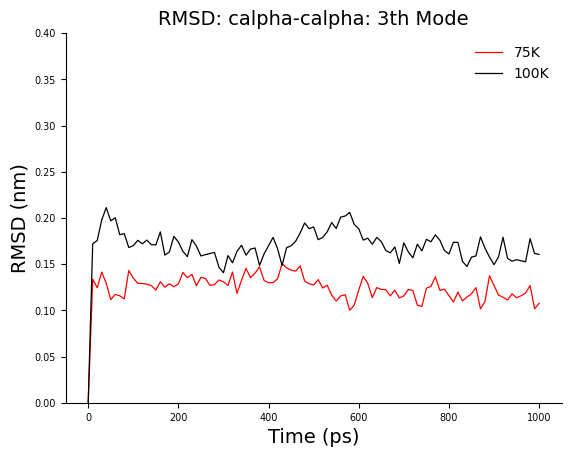

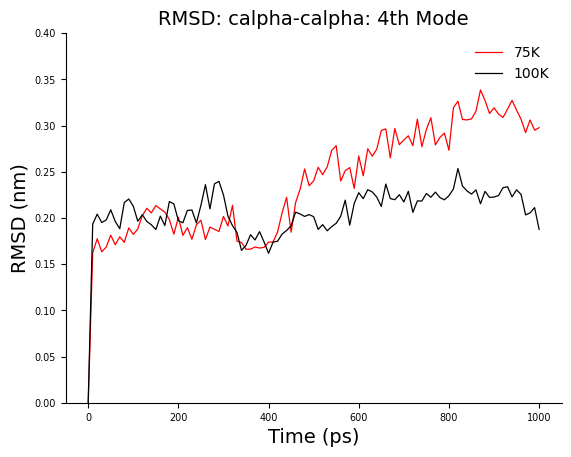

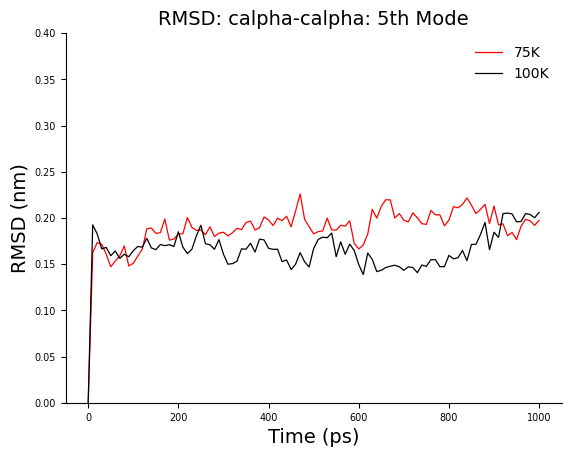

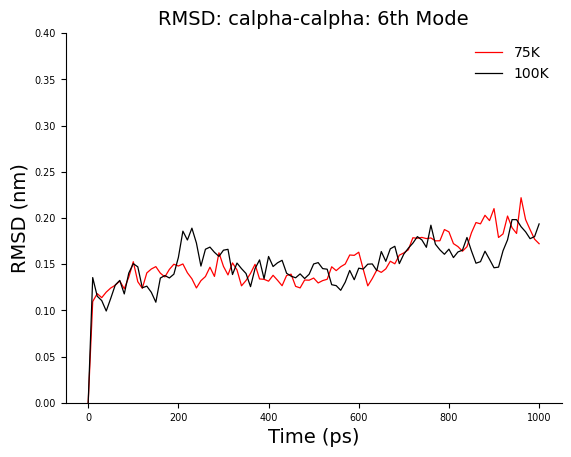

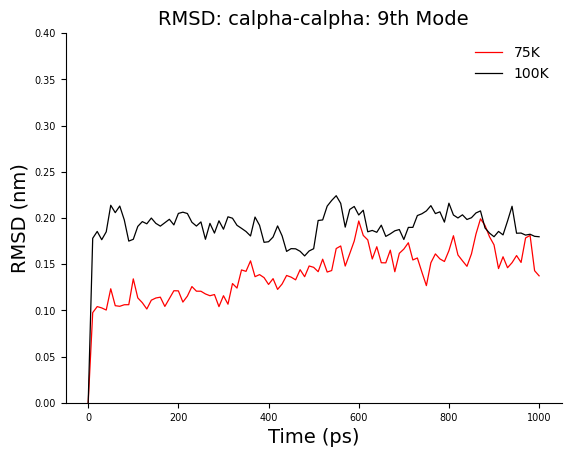

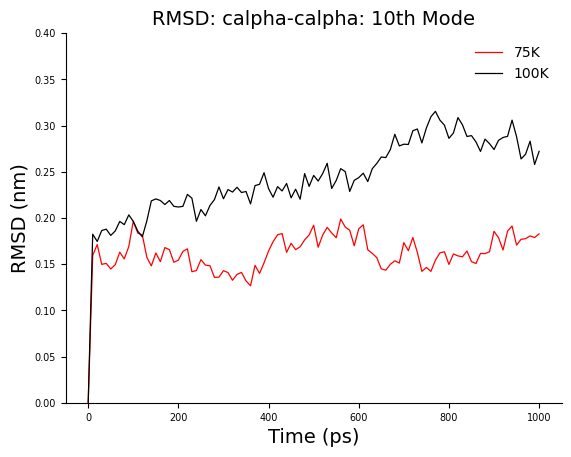

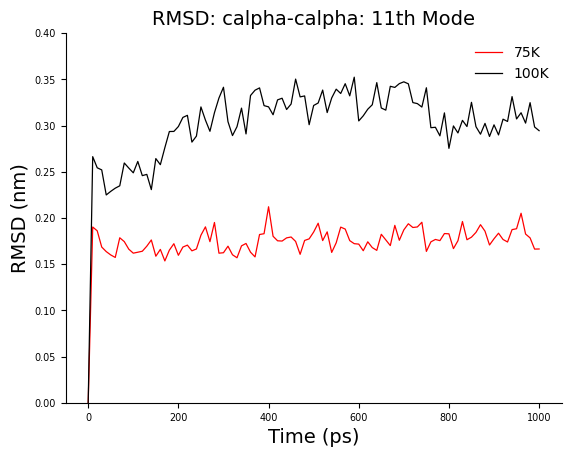

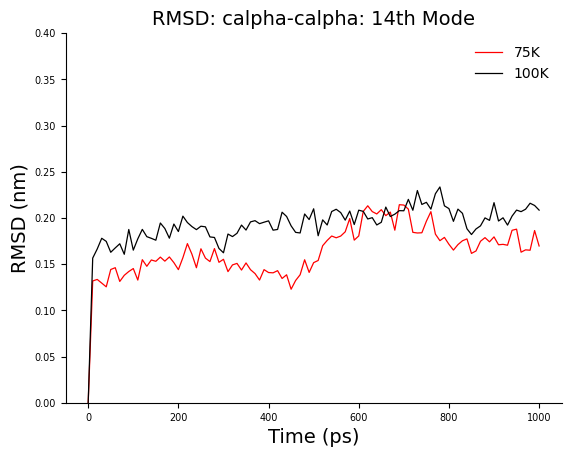

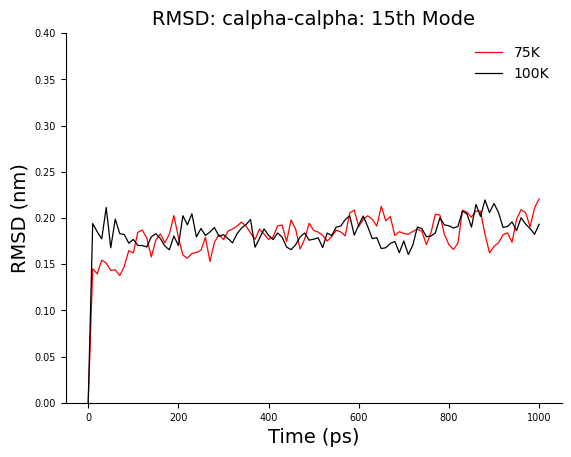

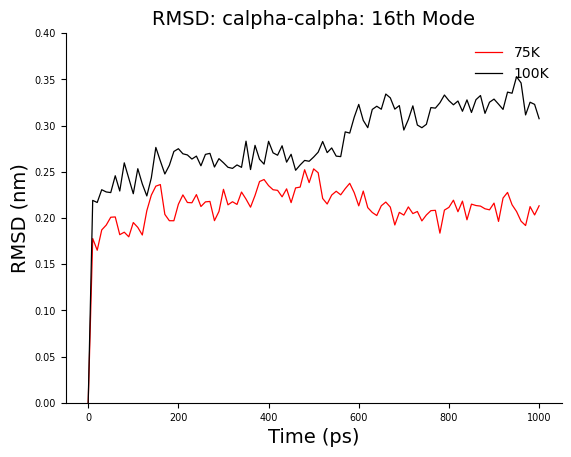

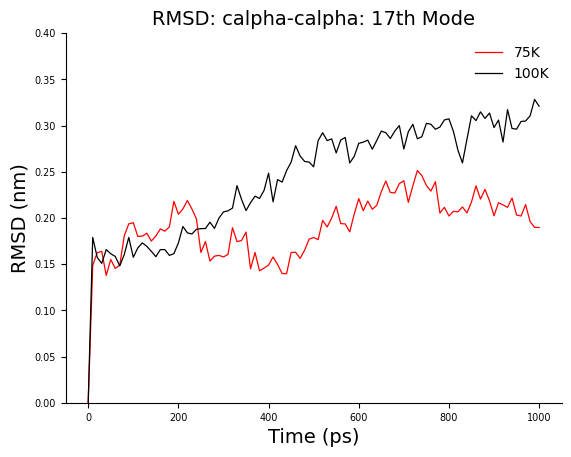

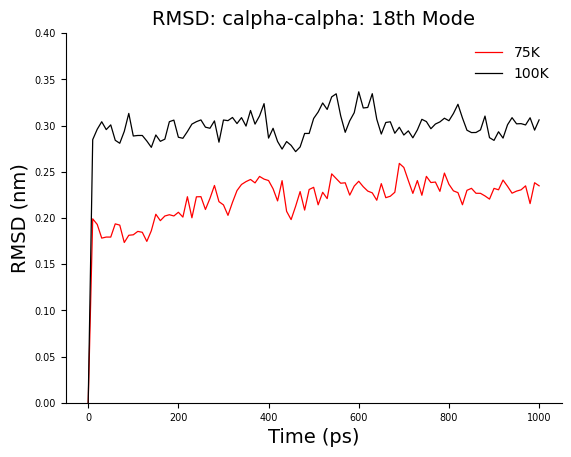

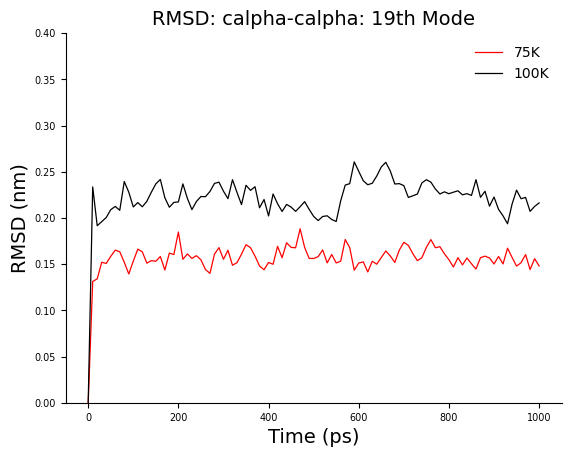

In [16]:
rmsdcc_75 = []
rmsdcc_100 = []

for i in range(20):
    filename = file_dir+"75_delT/{}_mode/rmsd_calpha_calpha.xvg".format(i)
    rmsd_75 = np.genfromtxt(filename, skip_header = 18)
    rmsdcc_75.append(rmsd_75[:, 1])
    filename = file_dir+"100_delT/{}_mode/rmsd_calpha_calpha.xvg".format(i)
    rmsd_100 = np.genfromtxt(filename, skip_header = 18)
    rmsdcc_100.append(rmsd_100[:, 1])
    plt.figure()
    ax = plt.subplot()
    plt.rc('font', family='sans-serif')
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')
    ax.plot(rmsd_75[:, 0], rmsd_75[:, 1], label = '75K', color = 'red', linewidth = 0.9)
    ax.plot(rmsd_100[:, 0], rmsd_100[:, 1], label = '100K', color = 'black', linewidth = 0.9)
    plt.xlabel("Time (ps)", fontsize = 14)
    plt.ylabel("RMSD (nm)", fontsize = 14)
    plt.ylim(0, 0.4)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title("RMSD: calpha-calpha: {}th Mode".format(i), fontsize = 14)
    plt.legend(frameon = False, loc ="upper right", ncol = 1, prop={'size':10})

Text(0.02, 0.5, 'RMSD (nm)')

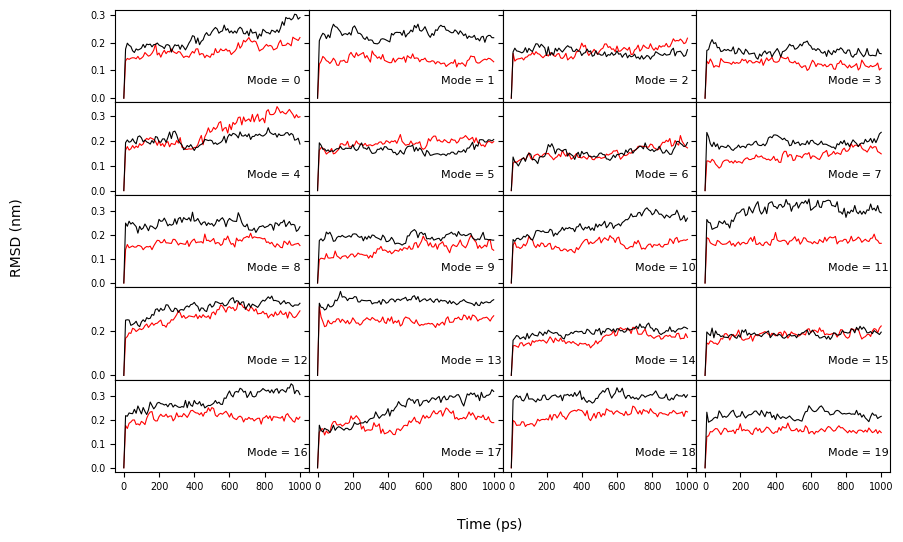

In [17]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(5, 4, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        axes[i, j].plot(time, rmsdcc_75[j+i+lc], color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(time, rmsdcc_100[j+i+lc], color = 'black', label = 'delT = 100K', linewidth=0.8)
        axes[i, j].text(700, 0.05, "Mode = {}".format(j+i+lc), fontsize = 8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.05)
#        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Time (ps)', fontsize = 10)
fig.supylabel('RMSD (nm)', fontsize = 10)

Text(0.02, 0.5, 'RMSD (nm)')

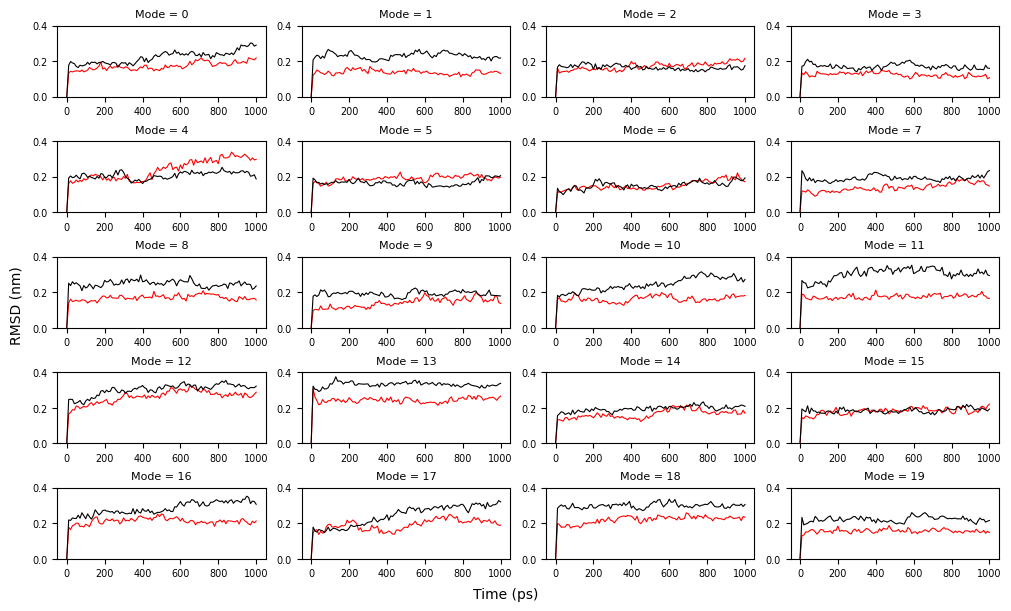

In [18]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        axes[i, j].plot(time, rmsdcc_75[j+i+lc], color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(time, rmsdcc_100[j+i+lc], color = 'black', label = 'delT = 100K', linewidth=0.8)
#        axes[i, j].legend(frameon = False, loc ="upper left", prop={'size':5})
        axes[i, j].set_ylim(0, 0.4)
        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD: calpha-calpha', fontsize = 14)
fig.supxlabel('Time (ps)', fontsize = 10)
fig.supylabel('RMSD (nm)', fontsize = 10)

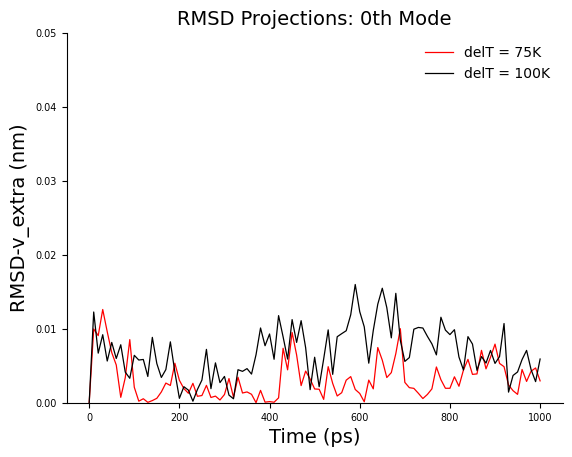

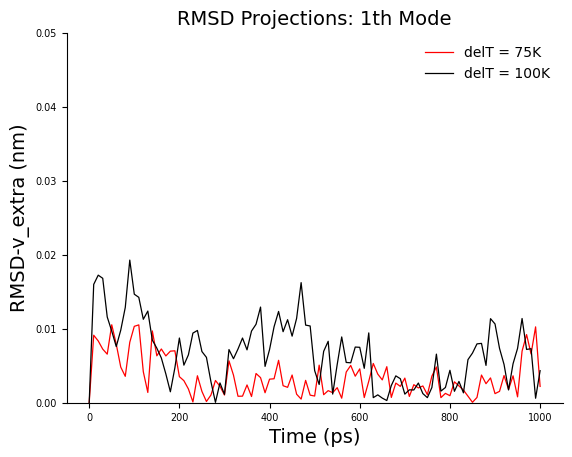

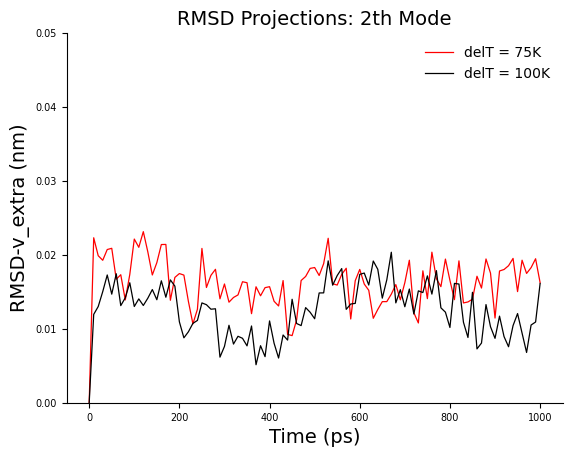

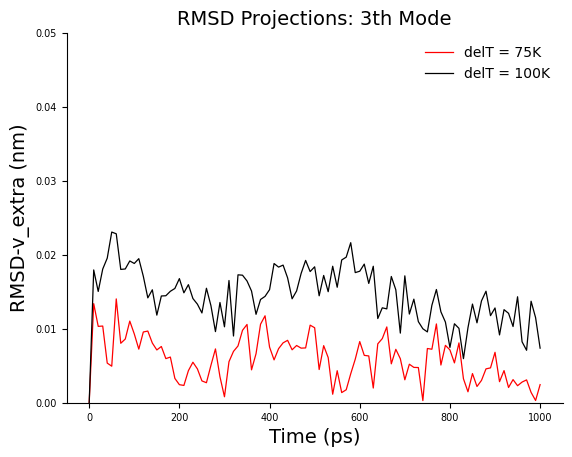

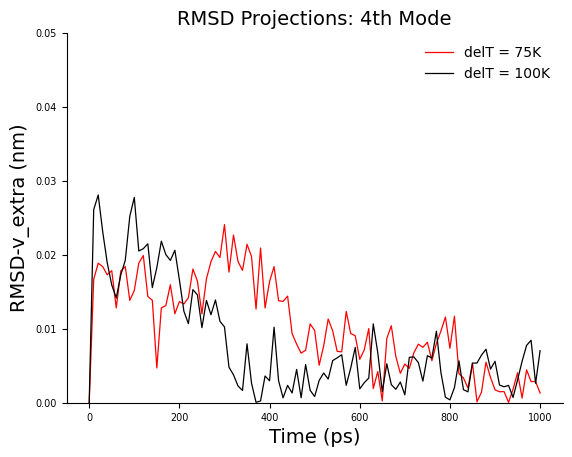

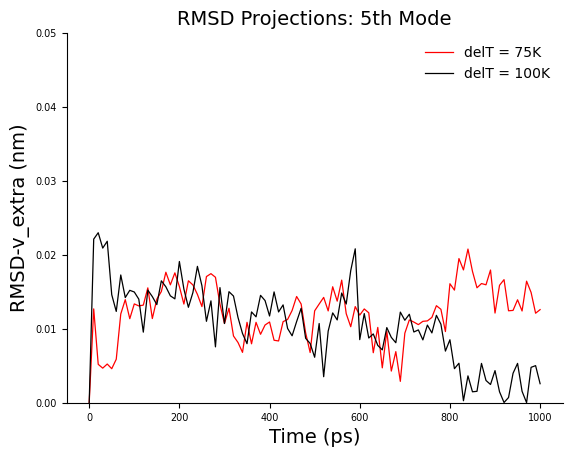

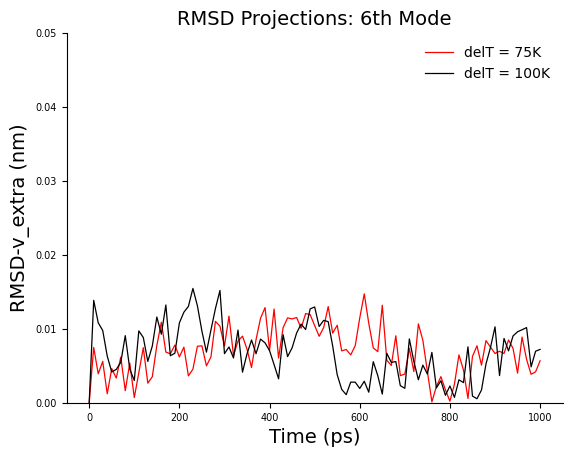

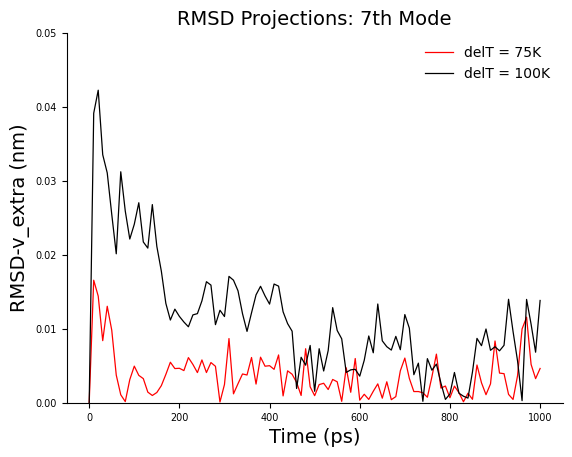

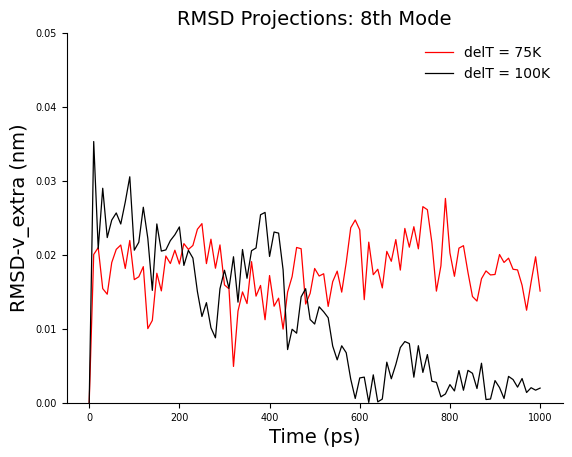

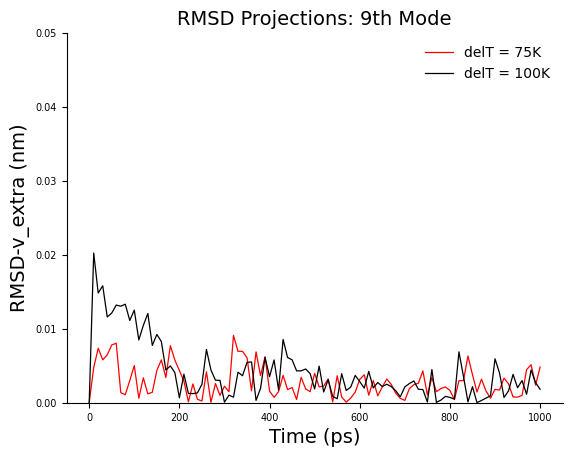

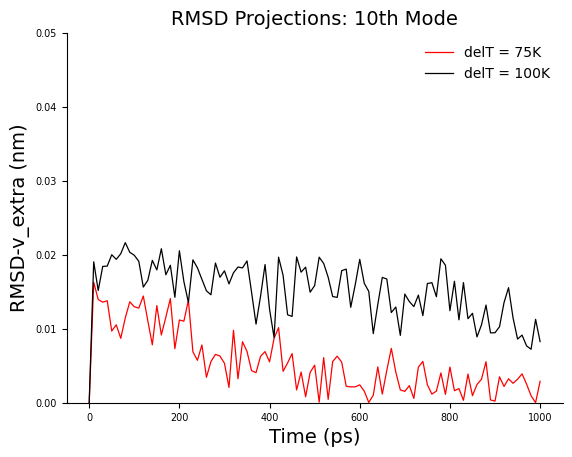

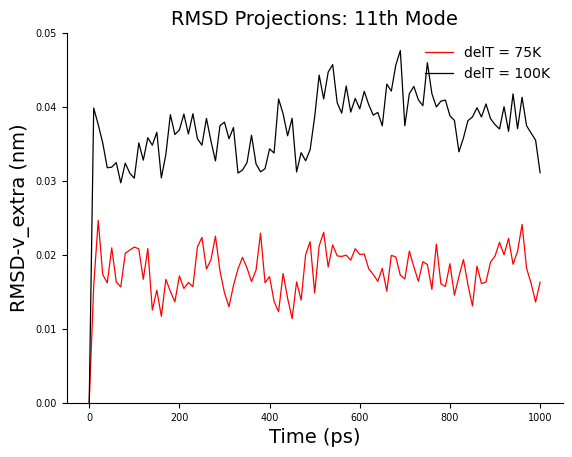

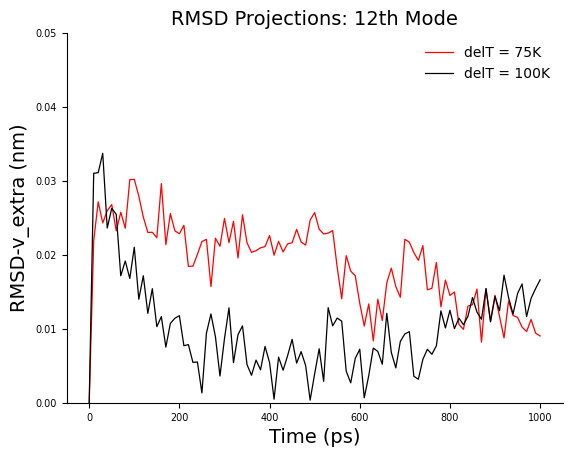

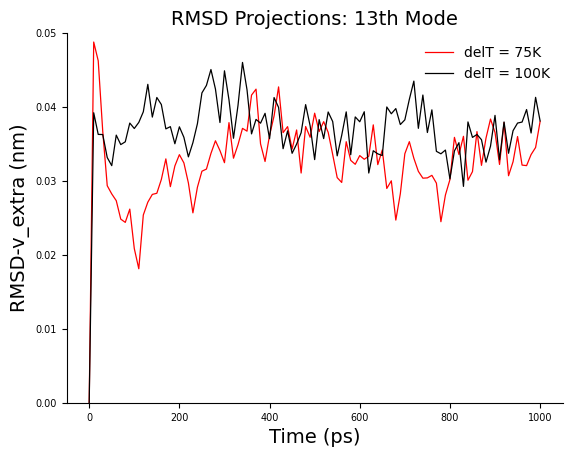

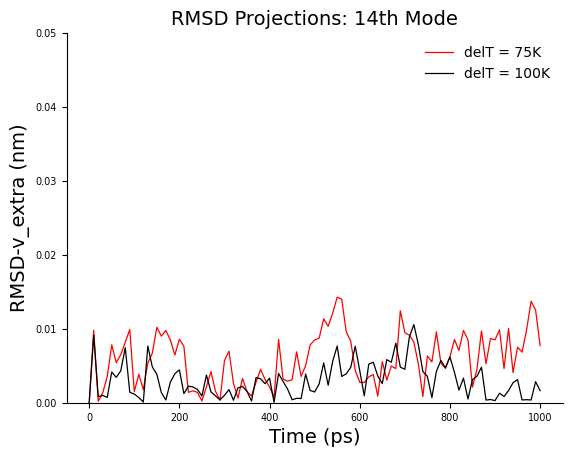

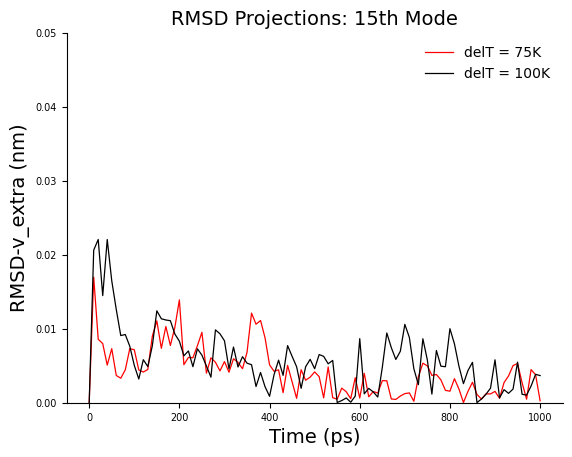

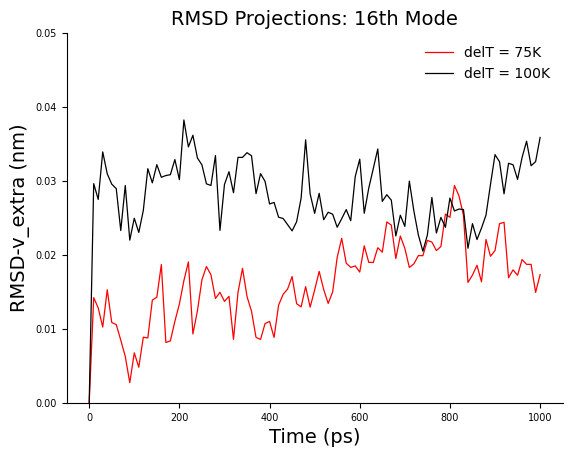

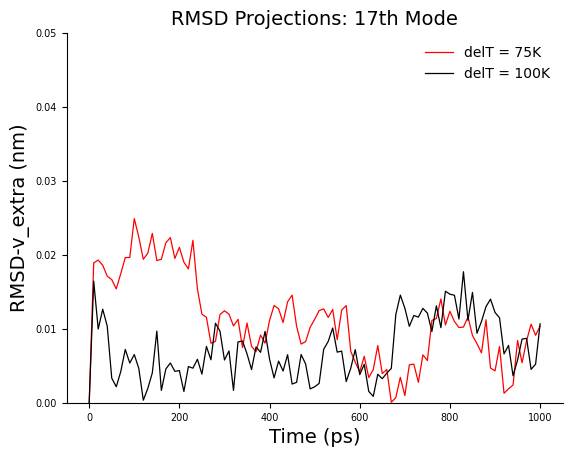

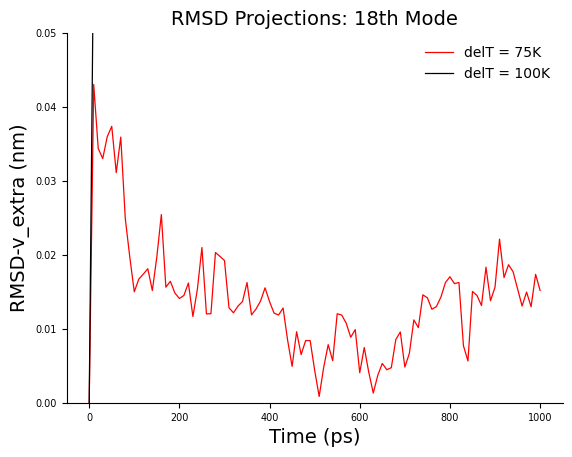

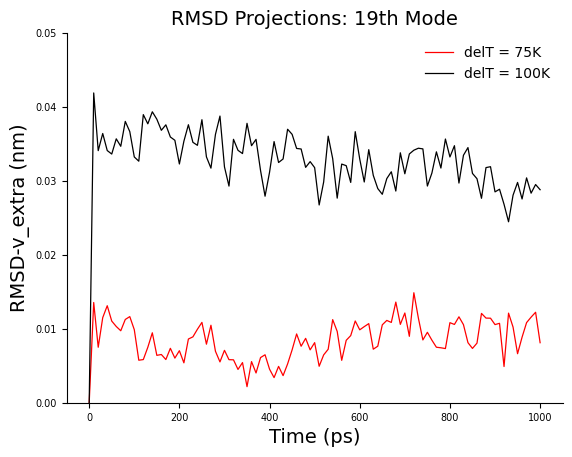

In [19]:
time = [i*10 for i in range(101)]

for i in range(20):
    fig, ax = plt.subplots()
    plt.rc('font', family='sans-serif')
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')
    ax.plot(time, rd_75[i], label = 'delT = 75K', color = 'red', linewidth = 0.9)
    ax.plot(time, rd_100[i], label = 'delT = 100K', color = 'black', linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':10})
    ax.set_xlabel('Time (ps)', fontsize = 14)
    ax.set_ylabel('RMSD-v_extra (nm)', fontsize = 14)
    ax.set_ylim(0, 0.05)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title('RMSD Projections: {}th Mode'.format(i), fontsize = 14)
    plt.show()

In [20]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
#fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(5, 4, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        axes[i, j].plot(time, rd_75[j+i+lc], color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(time, rd_100[j+i+lc], color = 'black', label = 'delT = 100K', linewidth=0.8)
#        axes[i, j].text(400, 0.035, "Mode = {}".format(j+i+lc), fontsize = 8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.05)
#        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Time (ps)', fontsize = 10)
fig.supylabel('RMSD-v_extra (nm)', fontsize = 10)

Text(0.02, 0.5, 'RMSD-v_extra (nm)')

Text(0.02, 0.5, 'RMSD-v_extra (nm)')

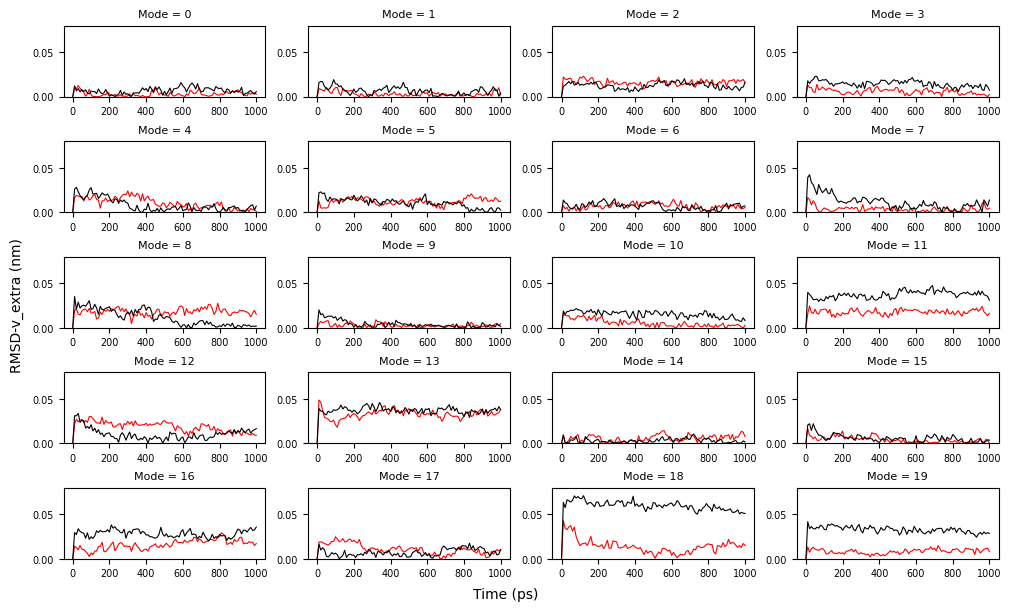

In [21]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        axes[i, j].plot(time, rd_75[j+i+lc], color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(time, rd_100[j+i+lc], color = 'black', label = 'delT = 100K', linewidth=0.8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
        axes[i, j].set_ylim(0, 0.08)
        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Time (ps)', fontsize = 10)
fig.supylabel('RMSD-v_extra (nm)', fontsize = 10)

Text(0.5, 1.0, 'B')

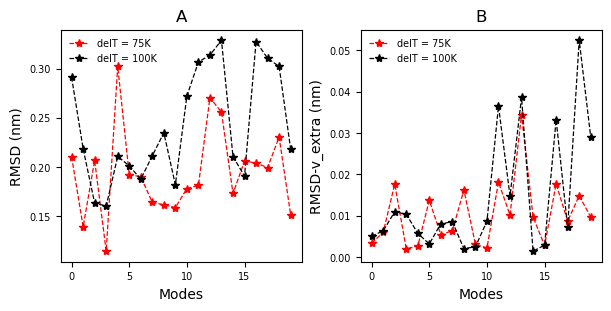

In [22]:
avg_rmsdcc_75 = []
avg_rmsdcc_100 = []
avg_rd_75 = []
avg_rd_100 = []
mode_lst = []
for k in range(20):
    avg_rmsdcc_75.append(np.average(rmsdcc_75[k][95:]))
    avg_rmsdcc_100.append(np.average(rmsdcc_100[k][95:]))
    avg_rd_75.append(np.average(rd_75[k][95:]))
    avg_rd_100.append(np.average(rd_100[k][95:]))
    mode_lst.append(k)
    

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), layout='constrained')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

axes[0].plot(mode_lst, avg_rmsdcc_75, '*', linestyle='dashed', color = 'red', label = 'delT = 75K', linewidth = 0.9)
axes[0].plot(mode_lst, avg_rmsdcc_100, '*', linestyle='dashed', color = 'black', label = 'delT = 100K', linewidth = 0.9)
axes[0].legend(frameon = False, loc ="upper left", prop={'size':7})
axes[0].set_xlabel("Modes", fontsize = 10)
axes[0].set_ylabel("RMSD (nm)", fontsize = 10)
axes[0].set_title("A", fontsize = 12)
axes[1].plot(mode_lst, avg_rd_75, '*', linestyle='dashed', color = 'red', label = 'delT = 75K', linewidth = 0.9)
axes[1].plot(mode_lst, avg_rd_100, '*', linestyle='dashed', color = 'black', label = 'delT = 100K', linewidth = 0.9)
axes[1].legend(frameon = False, loc ="upper left", prop={'size':7})
axes[1].set_xlabel("Modes", fontsize = 10)
axes[1].set_ylabel("RMSD-v_extra (nm)", fontsize = 10)
axes[1].set_title("B", fontsize = 12)

    
# fig, ax = plt.subplots()
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.plot(mode_lst, avg_rmsdcc_75, '*', linestyle='dashed', color = 'grey', label = 'delT = 75K')
# plt.plot(mode_lst, avg_rmsdcc_100, '*', linestyle='dashed', color = 'orange', label = 'delT = 100K')
# plt.xlabel("modes", fontsize = 14)
# plt.xticks(np.arange(min(mode_lst), max(mode_lst)+1, 1))
# plt.ylabel("RMSD (nm)", fontsize = 14)
# plt.title("Average RMSD for separate modes", fontsize = 14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.legend(frameon = False, loc ="upper right", ncol = 1, prop={'size':10})

# fig, ax = plt.subplots()
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.plot(mode_lst, avg_rd_75, '*', linestyle='dashed', color = 'grey', label = 'delT = 75K')
# plt.plot(mode_lst, avg_rd_100, '*', linestyle='dashed', color = 'orange', label = 'delT = 100K')
# plt.xlabel("modes", fontsize = 14)
# plt.xticks(np.arange(min(mode_lst), max(mode_lst)+1, 1))
# plt.ylabel("RMSD-v_extra (nm)", fontsize = 14)
# plt.title("Average RMSD projections for separate modes", fontsize = 14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.legend(frameon = False, loc ="upper left", ncol = 1, prop={'size':10})

Text(0.02, 0.5, 'RMSF (nm)')

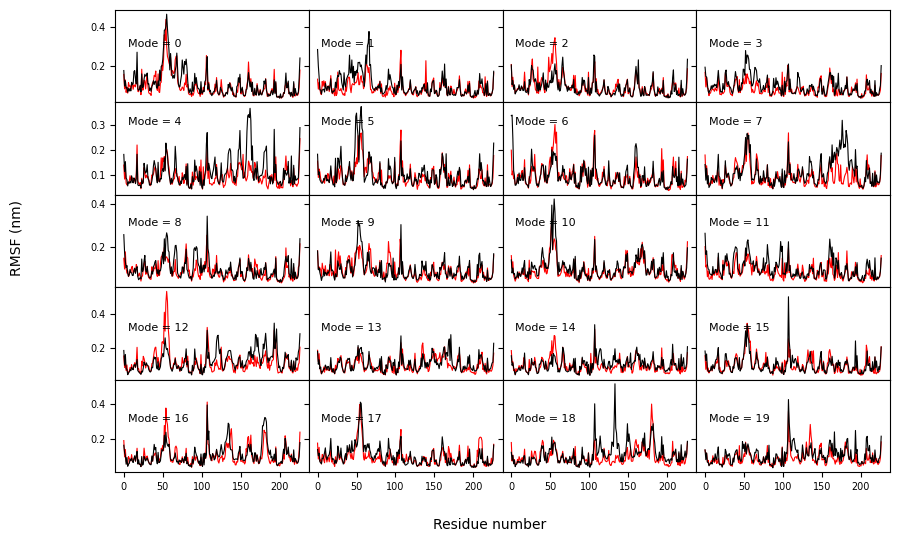

In [23]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
#fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(5, 4, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        rmsf_L = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_H = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_75 = np.hstack((rmsf_L, rmsf_H))
        rmsf_L = np.genfromtxt(file_dir+"100_delT/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_H = np.genfromtxt(file_dir+"100_delT/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_75 = np.hstack((rmsf_L, rmsf_H))
        axes[i, j].plot(range(227), rmsf_75, color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(range(227), rmsf_100, color = 'black', label = 'delT = 100K', linewidth=0.8)
        axes[i, j].text(5, 0.3, "Mode = {}".format(j+i+lc), fontsize = 8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.05)
#        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Residue number', fontsize = 10)
fig.supylabel('RMSF (nm)', fontsize = 10)

Text(0.02, 0.5, 'RMSF (nm)')

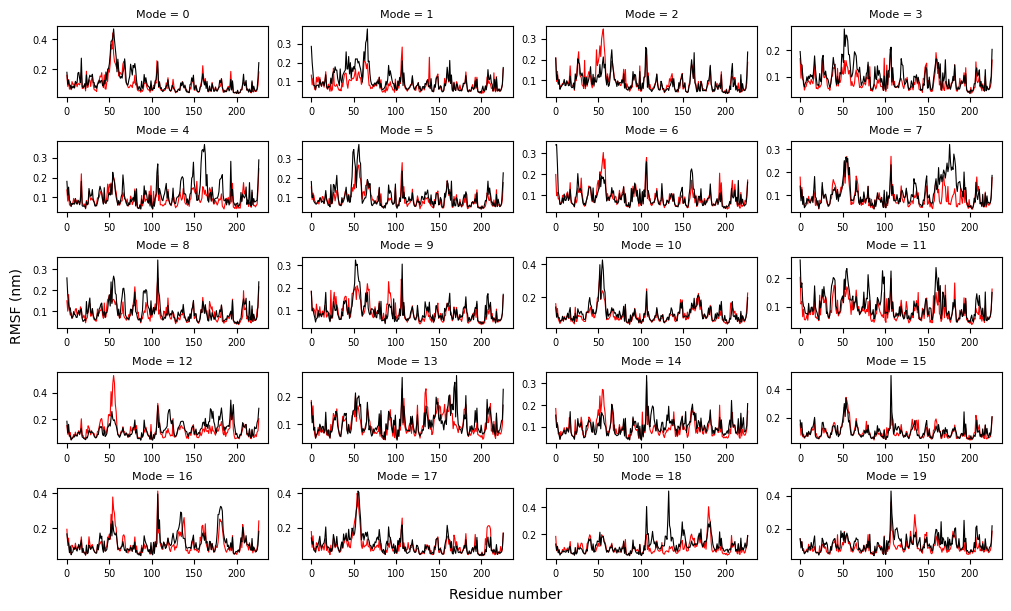

In [24]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        rmsf_L = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_H = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_75 = np.hstack((rmsf_L, rmsf_H))
        rmsf_L = np.genfromtxt(file_dir+"100_delT/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_H = np.genfromtxt(file_dir+"100_delT/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_75 = np.hstack((rmsf_L, rmsf_H))
        axes[i, j].plot(range(227), rmsf_75, color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(range(227), rmsf_100, color = 'black', label = 'delT = 100K', linewidth=0.8)
#        axes[i, j].text(5, 0.3, "Mode = {}".format(j+i+lc), fontsize = 8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.05)
        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Residue number', fontsize = 10)
fig.supylabel('RMSF (nm)', fontsize = 10)

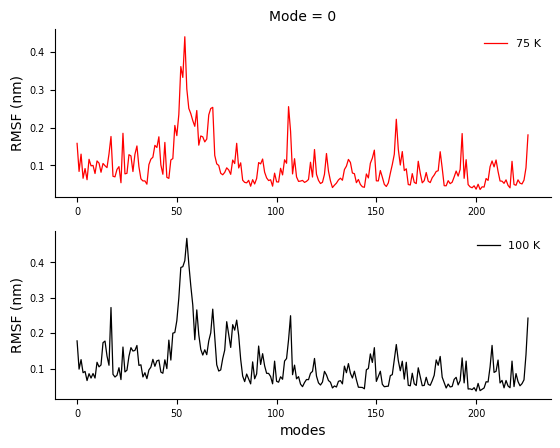

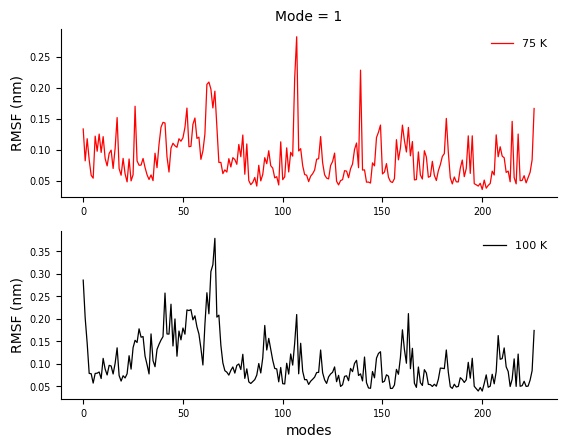

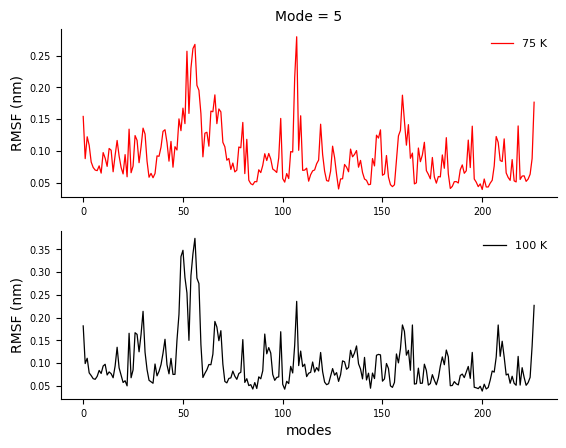

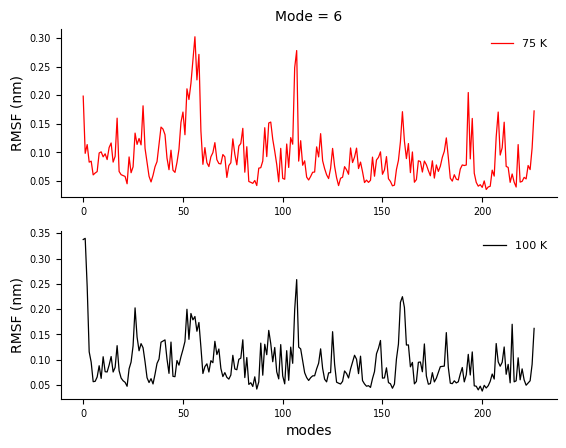

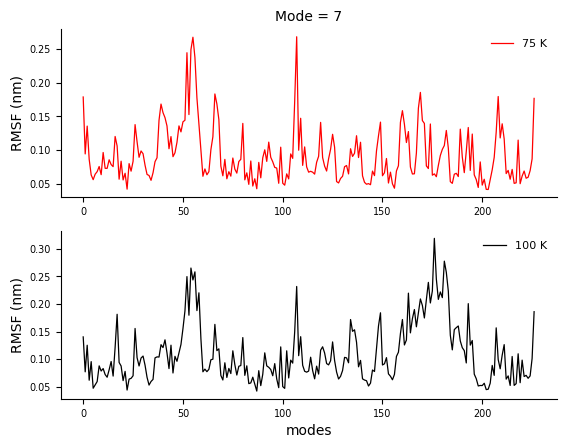

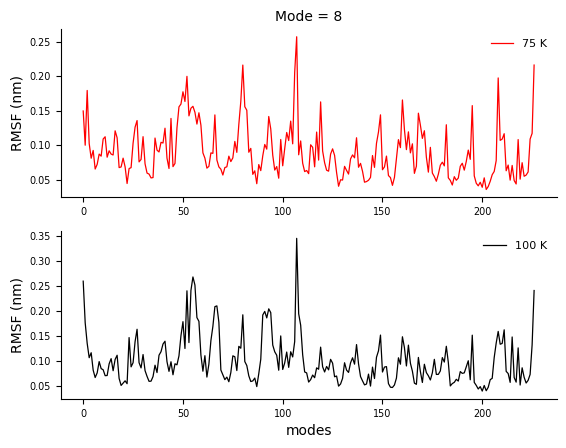

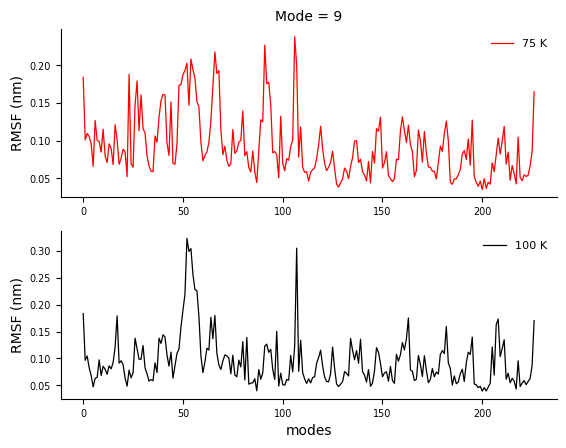

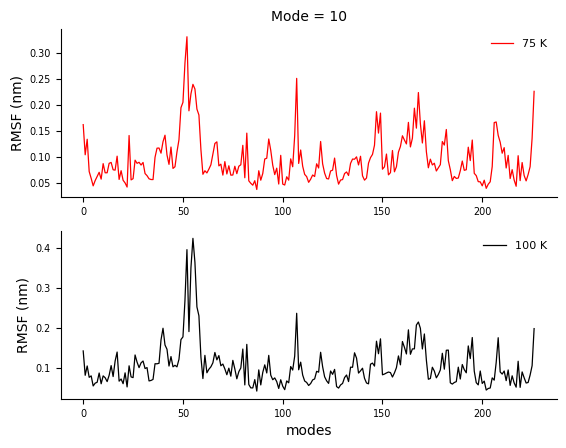

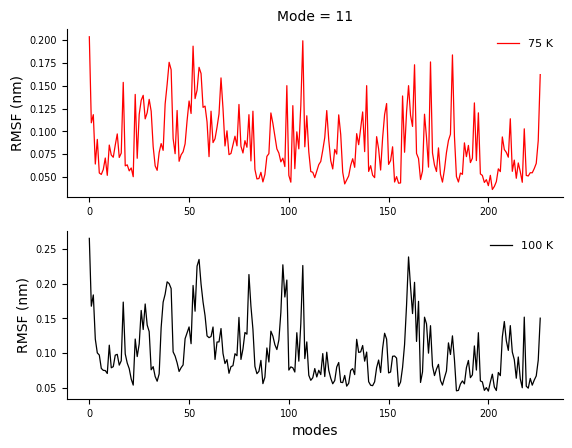

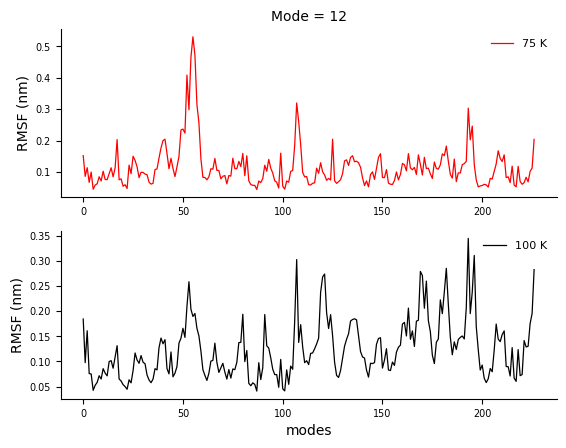

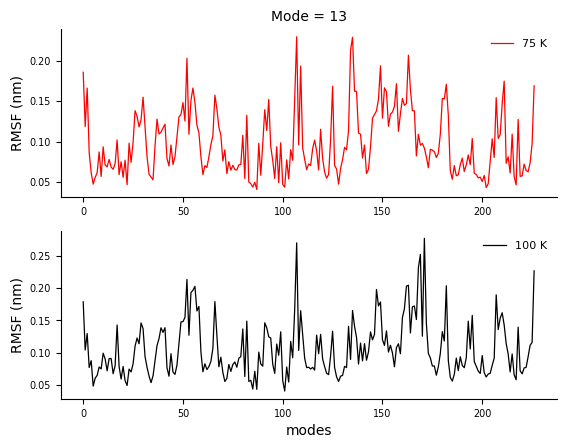

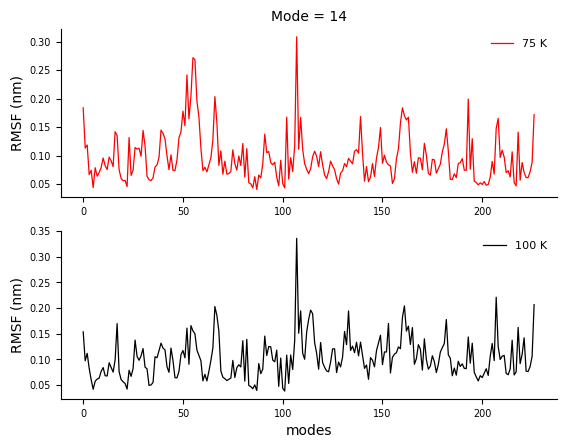

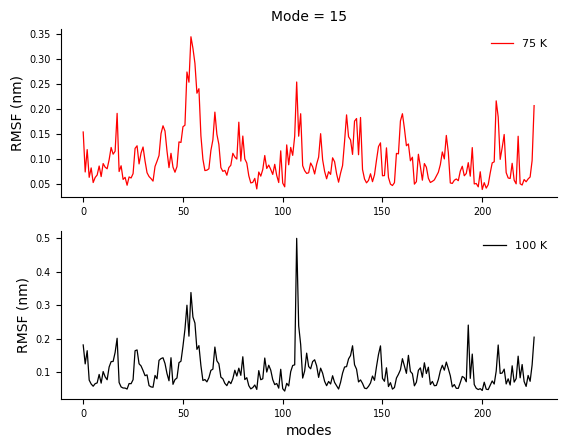

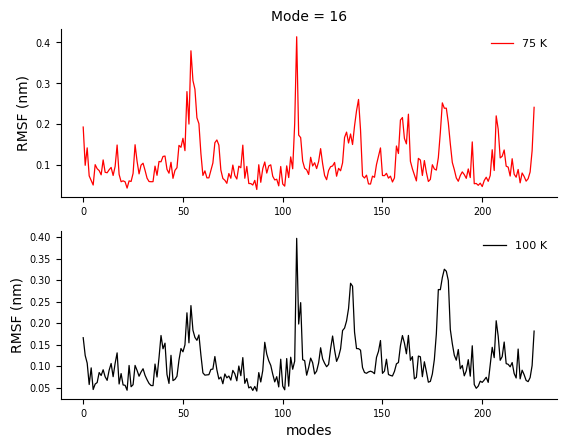

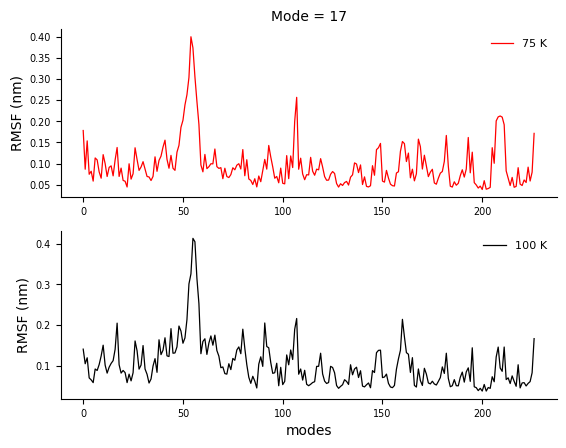

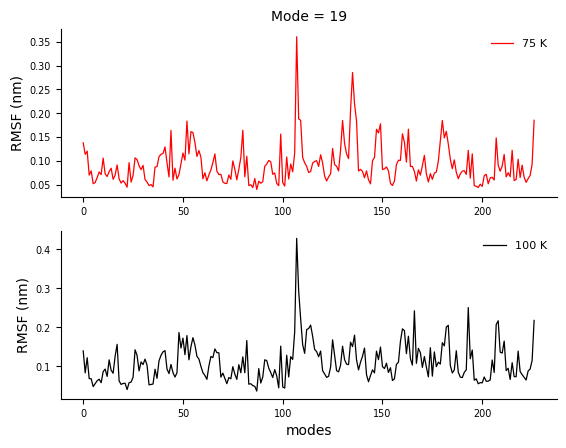

In [25]:
for i in range(20):
    rmsf_L = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
    rmsf_H = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
    rmsf_75 = np.hstack((rmsf_L, rmsf_H))
    rmsf_L = np.genfromtxt(file_dir+"100_delT/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
    rmsf_H = np.genfromtxt(file_dir+"100_delT/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
    rmsf_75 = np.hstack((rmsf_L, rmsf_H))
    fig, axes = plt.subplots(nrows=2,ncols=1)
    plt.rc('font', family='sans-serif')
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')
    axes[0].plot(rmsf_75, color = 'red', label = '75 K', linewidth = 0.9)
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[0].set_ylabel("RMSF (nm)", fontsize = 10)
    axes[0].set_title("Mode = {}".format(i), fontsize = 10)
    axes[0].legend(frameon = False,loc ="upper right", prop={'size':8})
    axes[1].plot(rmsf_100, color = 'black', label = '100 K', linewidth = 0.9)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[1].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1].set_xlabel("modes", fontsize = 10)
    axes[1].set_ylabel("RMSF (nm)", fontsize = 10)

#### delT = 75; Finding the alpha

In [26]:
wm = v[6:26]
Um = U_m[6:26]
m = len(Um)
alpha = np.random.rand(m, 1)

In [27]:
def argmin(alpha, wm):
    return 0.5 * np.sum(wm @ np.square(alpha))

def constraint(alpha, rd_75, m):
    summ = 0
    for i in range(m):
        summ += np.average(rd_75[i][95:])*alpha[i]
    return summ-xi

cons = {'type': 'eq', 'fun': constraint, 'args': (rd_75, m)}

1.2046301456347663e-12
[0.05745853 0.06144547 0.16729453 0.01180556 0.01394913 0.05528996
 0.01951695 0.02098136 0.04525899 0.00798797 0.00513335 0.0394356
 0.02165671 0.06892556 0.01826173 0.00505358 0.03072062 0.01412398
 0.02343953 0.01432995]
-1.3430354051102711e-11
[0.17164391 0.18463194 0.50194265 0.0356458  0.04181389 0.16565344
 0.05856459 0.06313969 0.13585083 0.02387645 0.01543563 0.11839173
 0.0650618  0.20668264 0.05484892 0.01517114 0.0921866  0.04233587
 0.07029994 0.04301049]
-3.145041171936924e-11
[0.2852341  0.30788238 0.83671221 0.05935173 0.0697271  0.27590669
 0.09760117 0.10532012 0.22646507 0.03969723 0.02574273 0.19735904
 0.10845725 0.34444965 0.09148224 0.02522822 0.15368166 0.07053386
 0.11715856 0.07167296]


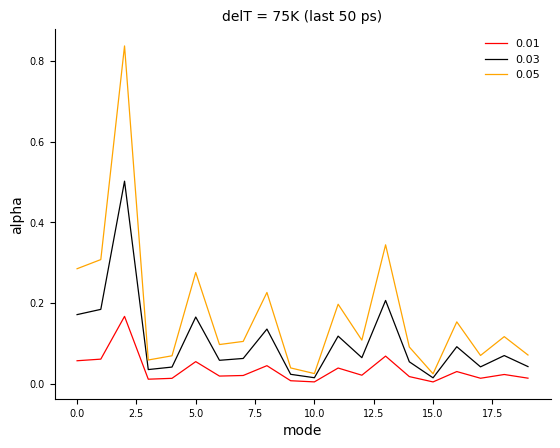

In [28]:
lst = [0.01, 0.03, 0.05]
alpha_75_5 = []
color = ['red', 'black', 'orange']
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
for i in lst:
    xi = i
    result = minimize(argmin, alpha.flatten(), args=(wm,), constraints=cons, method = 'SLSQP')
    alpha_m_75 = result.x
#    alpha_m_75 = alpha_m_75/np.linalg.norm(alpha_m_75)
    alpha_75_5.append(alpha_m_75)
    print(constraint(alpha_m_75, rd_75, m))
    print(alpha_m_75)
#     plt.plot(alpha_m_75, label = str(i))
#     plt.title("delT = 75 (last 50 ps)")
#     plt.xlabel("mode")
#     plt.ylabel("alpha")
#     plt.legend(loc ="upper right", ncol = 1, prop={'size':10})
    ax.plot(alpha_m_75, label = str(i), color = color[lst.index(i)], linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':8})
    ax.set_xlabel('mode', fontsize = 10)
    ax.set_ylabel('alpha', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("delT = 75K (last 50 ps)", fontsize = 10)
plt.show()

In [29]:
def argmin(alpha, wm):
    return 0.5 * np.sum(wm @ np.square(alpha))

def constraint(alpha, rd_75, m):
    summ = 0
    for i in range(m):
        summ += np.average(rd_75[i][80:])*alpha[i]
    return summ-xi

cons = {'type': 'eq', 'fun': constraint, 'args': (rd_75, m)}

In [30]:
lst = [0.01, 0.03, 0.05]
alpha_75_20 = []
color = ['red', 'black', 'orange']
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
for i in lst:
    xi = i
    result = minimize(argmin, alpha.flatten(), args=(wm,), constraints=cons, method = 'SLSQP')
    alpha_m_75 = result.x
    alpha_75_20.append(alpha_m_75)
    print(constraint(alpha_m_75, rd_75, m))
    print(alpha_m_75)
    ax.plot(alpha_m_75, label = str(i), color = color[lst.index(i)], linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':8})
    ax.set_xlabel('mode', fontsize = 10)
    ax.set_ylabel('alpha', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("delT = 75K (last 20% values)", fontsize = 10)
plt.show()

-1.3011761806902555e-12
[0.0694331  0.0327737  0.15922178 0.02107621 0.01637187 0.06241501
 0.02027677 0.01153792 0.04892145 0.00655205 0.00551528 0.03942675
 0.02513641 0.06853599 0.01489246 0.00379538 0.03551274 0.01275676
 0.02397081 0.01471025]
-1.245003058980565e-11
[0.20700083 0.09832018 0.47779559 0.06246817 0.04956789 0.18710767
 0.06088824 0.03487867 0.147077   0.01978802 0.01653807 0.11839173
 0.07563886 0.20548579 0.0447487  0.01162808 0.10647062 0.03821518
 0.07186452 0.04416925]
-1.2506190527616923e-11
[0.34484486 0.1639277  0.79638831 0.10414318 0.08260072 0.31171656
 0.10149147 0.05812261 0.24515151 0.03297467 0.02757964 0.19736183
 0.12609851 0.34244255 0.07461435 0.01938487 0.17748116 0.06365937
 0.11977199 0.07364241]


#### delT = 100; Finding the alpha

In [31]:
def argmin(alpha, wm):
    return 0.5 * np.sum(wm @ np.square(alpha))

def constraint(alpha, rd_100, m):
    summ = 0
    for i in range(m):
        summ += np.average(rd_100[i][95:])*alpha[i]
    return summ-xi

cons = {'type': 'eq', 'fun': constraint, 'args': (rd_100, m)}

In [32]:
lst = [0.01, 0.03, 0.05]
alpha_100_5 = []
color = ['red', 'black', 'orange']
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
for i in lst:
    xi = i
    result = minimize(argmin, alpha.flatten(), args=(wm,), constraints=cons, method = 'SLSQP')
    alpha_m_100 = result.x
    alpha_100_5.append(alpha_m_100)
    print(argmin(alpha_m_100, wm))
    print(alpha_m_100)
    ax.plot(alpha_m_100, label = str(i), color = color[lst.index(i)], linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':8})
    ax.set_xlabel('mode', fontsize = 10)
    ax.set_ylabel('alpha', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("delT = 100K (last 50 ps)", fontsize = 10)
plt.show()

0.062328068026137606
[0.0486149  0.03750468 0.05968515 0.03459649 0.01707037 0.00734349
 0.01675695 0.01618324 0.00329685 0.00368865 0.01146397 0.04551846
 0.01801081 0.04428393 0.00157236 0.00297772 0.0329723  0.00665731
 0.04741    0.02463974]
0.5609514923385139
[0.14575589 0.1122948  0.17905321 0.10350585 0.05120408 0.02213097
 0.05033701 0.04846747 0.00994117 0.01111692 0.03438545 0.13653796
 0.05411491 0.13280983 0.00473344 0.00892329 0.09906814 0.0201109
 0.14225328 0.07386101]
1.558198406428656
[0.24291523 0.18707555 0.298428   0.17241082 0.08533813 0.03691687
 0.08391639 0.08075199 0.01658395 0.01854246 0.05730572 0.22755685
 0.0902159  0.22133668 0.00789189 0.01486793 0.16515958 0.03355777
 0.23709821 0.12308617]


In [33]:
def argmin(alpha, wm):
    return 0.5 * np.sum(wm @ np.square(alpha))

def constraint(alpha, rd_100, m):
    summ = 0
    for i in range(m):
        summ += np.average(rd_100[i][80:])*alpha[i]
    return summ-xi

cons = {'type': 'eq', 'fun': constraint, 'args': (rd_100, m)}

In [34]:
lst = [0.01, 0.03, 0.05]
alpha_100_20 = []
color = ['red', 'black', 'orange']
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
for i in lst:
    xi = i
    result = minimize(argmin, alpha.flatten(), args=(wm,), constraints=cons, method = 'SLSQP')
    alpha_m_100 = result.x
    alpha_100_20.append(alpha_m_100)
    print(argmin(alpha_m_100, wm))
    print(alpha_m_100)
    ax.plot(alpha_m_100, label = str(i), color = color[lst.index(i)], linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':8})
    ax.set_xlabel('mode', fontsize = 10)
    ax.set_ylabel('alpha', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("delT = 100K (last 20% values)", fontsize = 10)
plt.show()

0.0627079497461912
[0.05867302 0.03491532 0.05970402 0.03643523 0.01250787 0.00723258
 0.01182647 0.01299919 0.00389328 0.00330655 0.01479009 0.04740361
 0.01630871 0.04143547 0.00225214 0.00331882 0.02900928 0.00957893
 0.05013668 0.0255611 ]
0.5643704465220347
[0.17588839 0.10408838 0.17916365 0.10891862 0.03749628 0.02188768
 0.03559175 0.03883976 0.01185035 0.0099602  0.04439296 0.14214977
 0.04905176 0.12431311 0.00680955 0.0099605  0.08724865 0.0289398
 0.15044207 0.07659974]
1.567695629223848
[0.29358888 0.17358236 0.29858535 0.18146997 0.06248764 0.03636127
 0.05936365 0.0647398  0.01962785 0.01660538 0.07389378 0.23698979
 0.08170667 0.20715733 0.01129636 0.01661187 0.14533399 0.04815957
 0.25074284 0.12769462]


Text(0.02, 0.5, 'alpha')

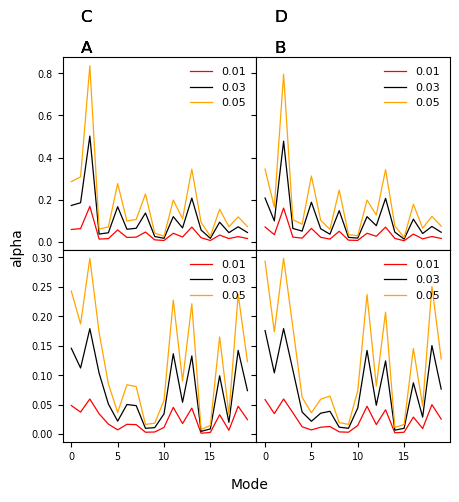

In [35]:
#fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5), layout='constrained')
fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

for i in range(3):
    axes[0, 0].plot(mode_lst, alpha_75_5[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[0, 0].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[0, 0].text(1, 0.9, "A", fontsize = 12)
    axes[0, 1].plot(mode_lst, alpha_75_20[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[0, 1].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[0, 1].text(1, 0.9, "B", fontsize = 12)
    axes[1, 0].plot(mode_lst, alpha_100_5[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[1, 0].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1, 0].text(1, 0.7, "C", fontsize = 12)
    axes[1, 1].plot(mode_lst, alpha_100_20[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[1, 1].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1, 1].text(1, 0.7, "D", fontsize = 12)
#fig.suptitle('Normal mode coefficients', fontsize = 14)
fig.supxlabel('Mode', fontsize = 10)
fig.supylabel('alpha', fontsize = 10)

Text(0.02, 0.5, 'alpha')

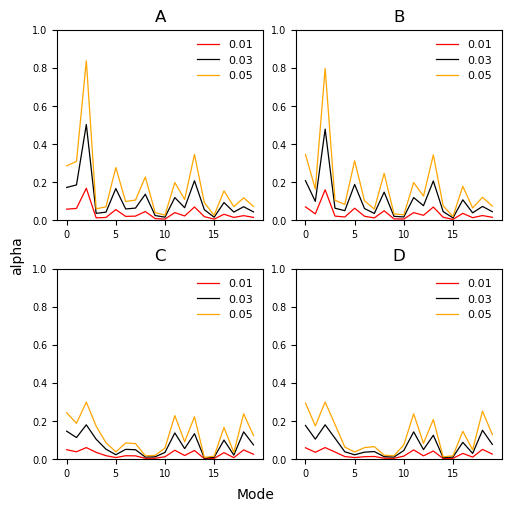

In [36]:
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5), layout='constrained')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

for i in range(3):
    axes[0, 0].plot(mode_lst, alpha_75_5[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[0, 0].set_ylim(0, 1.0)
    axes[0, 0].set_title('A', fontsize = 12)
    axes[0, 0].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[0, 1].plot(mode_lst, alpha_75_20[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[0, 1].set_ylim(0, 1.0)
    axes[0, 1].set_title('B', fontsize = 12)
    axes[0, 1].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1, 0].plot(mode_lst, alpha_100_5[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[1, 0].set_ylim(0, 1.0)
    axes[1, 0].set_title('C', fontsize = 12)
    axes[1, 0].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1, 1].plot(mode_lst, alpha_100_20[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[1, 1].set_ylim(0, 1.0)
    axes[1, 1].set_title('D', fontsize = 12)
    axes[1, 1].legend(frameon = False, loc ="upper right", prop={'size':8})
#fig.suptitle('Normal mode coefficients', fontsize = 14)
fig.supxlabel('Mode', fontsize = 10)
fig.supylabel('alpha', fontsize = 10)

In [37]:
d_75_5 = np.zeros((3, Um[0].shape[0]))
d_75_20 = np.zeros((3, Um[0].shape[0]))
d_100_5 = np.zeros((3, Um[0].shape[0]))
d_100_20 = np.zeros((3, Um[0].shape[0]))
for i in range(m):
    for j in range(3):
        d_75_5[j] += alpha_75_5[j][i]*Um[i]
        d_75_20[j] += alpha_75_20[j][i]*Um[i]
        d_100_5[j] += alpha_100_5[j][i]*Um[i]
        d_100_20[j] += alpha_100_20[j][i]*Um[i]
        d_75_5[j] = d_75_5[j]/np.linalg.norm(d_75_5[j])
        d_75_20[j] = d_75_20[j]/np.linalg.norm(d_75_20[j])
        d_100_5[j] = d_100_5[j]/np.linalg.norm(d_100_5[j])
        d_100_20[j] = d_100_20[j]/np.linalg.norm(d_100_20[j])

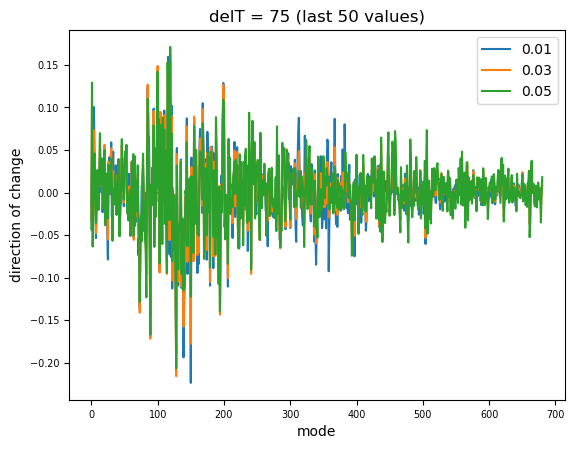

In [38]:
xi_lst = [0.01, 0.03, 0.05]
for i in range(3):
    plt.plot(d_75_5[i], label = str(xi_lst[i]))
    plt.title("delT = 75 (last 50 values)")
    plt.xlabel("mode")
    plt.ylabel("direction of change")
    plt.legend(loc ="upper right", ncol = 1, prop={'size':10})

In [39]:
for i in range(3):
    plt.plot(d_75_20[i], label = str(xi_lst[i]))
    plt.title("delT = 75 (last 20% values)")
    plt.xlabel("mode")
    plt.ylabel("direction of change")
    plt.legend(loc ="upper right", ncol = 1, prop={'size':10})

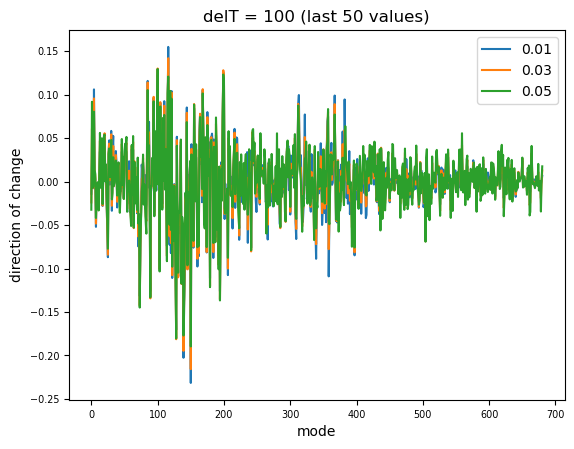

In [40]:
for i in range(3):
    plt.plot(d_100_5[i], label = str(xi_lst[i]))
    plt.title("delT = 100 (last 50 values)")
    plt.xlabel("mode")
    plt.ylabel("direction of change")
    plt.legend(loc ="upper right", ncol = 1, prop={'size':10})

In [41]:
for i in range(3):
    plt.plot(d_100_20[i], label = str(xi_lst[i]))
    plt.title("delT = 100 (last 20% values)")
    plt.xlabel("mode")
    plt.ylabel("direction of change")
    plt.legend(loc ="upper right", ncol = 1, prop={'size':10})

In [42]:
all_d = []
for i in range(3):
    all_d.append(d_75_5[i])
for i in range(3):
    all_d.append(d_75_20[i])
for i in range(3):
    all_d.append(d_100_5[i])
for i in range(3):
    all_d.append(d_100_20[i])

In [43]:
dot_product = np.zeros((len(all_d), len(all_d)))
for i in range(len(all_d)):
    for j in range(len(all_d)):
        dot_product[i, j] = np.dot(all_d[i], all_d[j])

In [44]:
dot_product

array([[1.        , 0.92355305, 0.76134579, 0.99943008, 0.92969622,
        0.77456594, 0.99100434, 0.97379429, 0.90384076, 0.99070666,
        0.97392909, 0.90548371],
       [0.92355305, 1.        , 0.9501711 , 0.91930264, 0.99616486,
        0.95036861, 0.8731186 , 0.93519015, 0.93978282, 0.87197585,
        0.93277422, 0.93737587],
       [0.76134579, 0.9501711 , 1.        , 0.75573232, 0.94160087,
        0.99336094, 0.6867889 , 0.80809047, 0.87497374, 0.6850329 ,
        0.80371806, 0.86926041],
       [0.99943008, 0.91930264, 0.75573232, 1.        , 0.92838745,
        0.77276374, 0.99179151, 0.97268522, 0.90131497, 0.99157223,
        0.97304988, 0.9032786 ],
       [0.92969622, 0.99616486, 0.94160087, 0.92838745, 1.        ,
        0.95182812, 0.88269872, 0.93988331, 0.94039734, 0.88174944,
        0.93804207, 0.93880054],
       [0.77456594, 0.95036861, 0.99336094, 0.77276374, 0.95182812,
        1.        , 0.70453226, 0.8199883 , 0.88170463, 0.70301072,
        0.81631717,

## 3. Friction matrix 

In [45]:
# saving after every 0.001 seconds, simulation length = 200ps
vel = np.loadtxt(file_dir+"vel.xvg", comments=["@", "#"], unpack=True)
time = vel[0]
vel = vel[1:]

In [46]:
len(vel[0])

200001

In [47]:
vel_x = np.zeros((len(time), n_res))
vel_y = np.zeros((len(time), n_res))
vel_z = np.zeros((len(time), n_res))
for j in range(len(time)):
    vel_xx = []
    vel_yy = []
    vel_zz = []
    for i in range(0, n_res):
        vel_xx.append(vel[i*3+0][j])
        vel_yy.append(vel[i*3+1][j])
        vel_zz.append(vel[i*3+2][j])
    vel_x[j] = vel_xx
    vel_y[j] = vel_yy
    vel_z[j] = vel_zz

In [48]:
# Compute omega and initialize velocity array
n_l = n_res
m_l = n_l * 3
n = len(time)
velocity = np.zeros((m_l, n))
velocity[0:m_l:3, :] = vel_x.T
velocity[1:m_l:3, :] = vel_y.T
velocity[2:m_l:3, :] = vel_z.T

# Compute correlation function
cvv = np.zeros((11, m_l), dtype=np.float32)
for frame_diff in range(0, 11):
    velacc = np.zeros((1, m_l), dtype=np.float32)
    ind = 0
    for frame in range(199991):
        ind += 1
        velacc += np.transpose(velocity[:, frame] * velocity[:, frame + frame_diff])
    velacc /= ind
    cvv[frame_diff, :] = velacc[0]

In [49]:
for i in range(11):
    plt.plot(cvv[i], label = str(i))
#plt.title("Cvv matrix")
plt.legend(loc ="upper right", ncol = 2, prop={'size':10})
plt.xlabel("Number of velocities")
plt.ylabel("Cvv matrix values")

Text(0, 0.5, 'Cvv matrix values')

Text(0, 0.5, 'Cvv values')

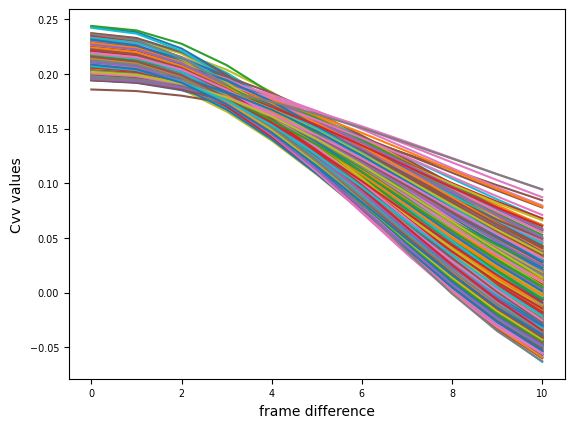

In [50]:
for i in range(681):
    plt.plot(cvv[:, i])
plt.xlabel("frame difference")
plt.ylabel("Cvv values")

In [51]:
# Compute friction and friction_NM: 0th and 5th frame each 681 entries....difference in cvv divide by time -> friction matrix (daig) element wise division
friction = cvv[4, :] - cvv[0, :]
friction = -friction/(5*0.001)
residue_mass = CA.residues.masses/1000
residue_mass = np.repeat(residue_mass, 3)
for i in range(681):
    friction[i] = friction[i]/residue_mass[i]
friction = friction/(8.3144*310*0.001) # ps-1
friction = np.diag(friction)
print(friction)
friction_NM = []
for i in range(20):
    friction_NM.append(Um[i].T @ friction @ Um[i])
print(friction_NM)

[[30.06301   0.        0.       ...  0.        0.        0.      ]
 [ 0.       34.385956  0.       ...  0.        0.        0.      ]
 [ 0.        0.       33.332474 ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ... 30.62322   0.        0.      ]
 [ 0.        0.        0.       ...  0.       40.584187  0.      ]
 [ 0.        0.        0.       ...  0.        0.       46.821976]]
[44.66632459398126, 43.882485689857816, 43.08672438844041, 41.8899025298834, 42.18272595548878, 42.935156283350686, 41.88496796608834, 41.00887586369411, 41.21458837677173, 44.39629350169342, 43.2172114878785, 42.96998367643636, 39.62212046940577, 42.38690911423231, 42.153183138444874, 41.6395475954045, 42.083336655510706, 43.68435403726712, 41.473406975405084, 42.44528757649256]


## 4. Estimating beta_m 

In [52]:
#for delT = 75
a = np.zeros(m)
b = np.zeros(m)
beta_m_75 = np.zeros(m)
for i in range(m):
    a[i] = 0.5 * (-friction_NM[i] + np.sqrt(np.abs(friction_NM[i]**2 - 4*wm[i]**2)))
    b[i] = 0.5 * (-friction_NM[i] - np.sqrt(np.abs(friction_NM[i]**2 - 4*wm[i]**2)))
    beta_m_75[i] = alpha_75_20[1][i] * (a[i]-b[i]) / ((np.abs(a[i]/b[i])**(a[i]/(b[i]-a[i])) - np.abs(a[i]/b[i])**(b[i]/(b[i]-a[i]))))
print(beta_m_75)
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(beta_m_75, '*', linestyle='dashed', color = 'black', linewidth = 0.9)
ax.set_xlabel('mode', fontsize = 10)
ax.set_ylabel('beta_m', fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("delT = 75 K", fontsize = 10)

[ 9.2935857   4.36624205 20.87446509  2.70041822  2.1696279   8.46502101
  2.71680038  1.54020368  6.65221894  0.96490302  0.80029571  5.74957478
  3.44630386 10.00595918  2.19329645  0.57057939  5.29907514  1.98833085
  3.61020563  2.29467971]


Text(0.5, 1.0, 'delT = 75 K')

[7.89675016 4.6223986  7.82750083 4.70841099 1.64124354 0.99023017
 1.58808473 1.71512066 0.53598519 0.48567901 2.14822513 6.90336004
 2.23492636 6.05332326 0.33376099 0.48875261 4.34239201 1.5057341
 7.55764924 3.97950807]


Text(0.5, 1.0, 'delT = 100 K')

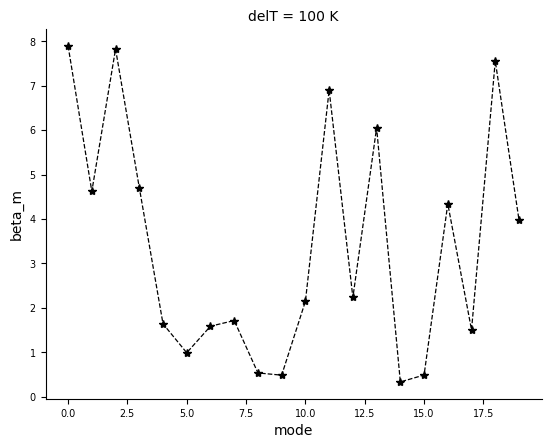

In [53]:
#for delT = 100
a = np.zeros(m)
b = np.zeros(m)
beta_m_100 = np.zeros(m)
for i in range(m):
    a[i] = 0.5 * (-friction_NM[i] + np.sqrt(np.abs(friction_NM[i]**2 - 4*wm[i]**2)))
    b[i] = 0.5 * (-friction_NM[i] - np.sqrt(np.abs(friction_NM[i]**2 - 4*wm[i]**2)))
    beta_m_100[i] = alpha_100_20[1][i] * (a[i]-b[i]) / ((np.abs(a[i]/b[i])**(a[i]/(b[i]-a[i])) - np.abs(a[i]/b[i])**(b[i]/(b[i]-a[i]))))
print(beta_m_100)
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(beta_m_100, '*', linestyle='dashed', color = 'black', linewidth = 0.9)
ax.set_xlabel('mode', fontsize = 10)
ax.set_ylabel('beta_m', fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("delT = 100 K", fontsize = 10)

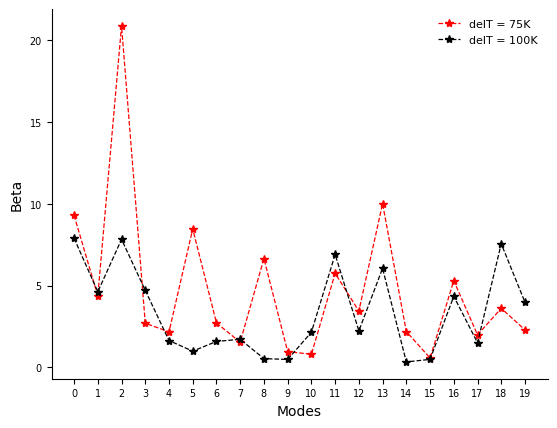

In [54]:
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.plot(mode_lst, beta_m_75, '*', linestyle='dashed', color = 'red', label = 'delT = 75K', linewidth = 0.9)
plt.plot(mode_lst, beta_m_100, '*', linestyle='dashed', color = 'black', label = 'delT = 100K', linewidth = 0.9)
plt.xlabel("Modes", fontsize = 10)
plt.xticks(np.arange(min(mode_lst), max(mode_lst)+1, 1))
plt.ylabel("Beta", fontsize = 10)
#plt.title("Average RMSD for separate modes", fontsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon = False, loc ="upper right", ncol = 1, prop={'size':8})

## 5. Degree of excitation 

In [55]:
# for delT = 75
v_extra = np.zeros(Um[0].shape)
for i in range(m):
    v_extra += beta_m_75[i]*Um[i]
#    v_extra = v_extra/np.linalg.norm(v_extra)
M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

v_excite = np.zeros(antibody.n_atoms*3)
for i in range(antibody.n_residues):
    for j in antibody.residues[i].atoms.indices:
        v_excite[3*j] = v_extra[3*i]
        v_excite[3*j+1] = v_extra[3*i+1]
        v_excite[3*j+2] =  v_extra[3*i+2]
u = mda.Universe(box,box)
alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2) #lambda in nm/ps
#lmda = (alpha* 75)**0.5

In [56]:
delT = range(0, 100)
lam_75 = []
for k in delT:
    lam_75.append((alpha*k)**0.5)
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(delT, lam_75, color = 'black', linewidth = 0.9)
ax.set_xlabel("delT (K)", fontsize = 10)
ax.set_ylabel("lambda (nm/ps)", fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("delT = 75 K", fontsize = 10)

Text(0.5, 1.0, 'delT = 75 K')

In [ ]:
# for delT = 100
v_extra = np.zeros(Um[0].shape)
for i in range(m):
    v_extra += beta_m_100[i]*Um[i]
#    v_extra = v_extra/np.linalg.norm(v_extra)
M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

v_excite = np.zeros(antibody.n_atoms*3)
for i in range(antibody.n_residues):
    for j in antibody.residues[i].atoms.indices:
        v_excite[3*j] = v_extra[3*i]
        v_excite[3*j+1] = v_extra[3*i+1]
        v_excite[3*j+2] =  v_extra[3*i+2]
u = mda.Universe(box,box)
alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2) #lambda in nm/ps
#lmda = (alpha* 75)**0.5

Text(0.5, 1.0, 'delT = 100 K')

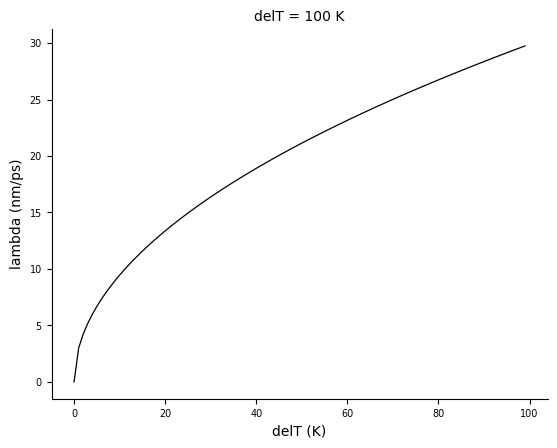

In [57]:
delT = range(0, 100)
lam_100 = []
for k in delT:
    lam_100.append((alpha*k)**0.5)
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(delT, lam_100, color = 'black', linewidth = 0.9)
ax.set_xlabel("delT (K)", fontsize = 10)
ax.set_ylabel("lambda (nm/ps)", fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("delT = 100 K", fontsize = 10)

In [58]:
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.plot(delT, lam_75, '*', linestyle='dashed', color = 'red', label = 'delT = 75K', linewidth = 0.9)
plt.plot(delT, lam_100, '*', linestyle='dashed', color = 'black', label = 'delT = 100K', linewidth = 0.9)
plt.xlabel("delT (K)", fontsize = 10)
#plt.xticks(np.arange(min(mode_lst), max(mode_lst)+1, 1))
plt.ylabel("lambda (nm/ps)", fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon = False, loc ="lower right", ncol = 1, prop={'size':8})

### Excitation along normal modes

In [86]:
box = file_dir+"box.pdb"
pdb = file_dir+"pdb_ref.pdb"
x = mda.Universe(pdb, pdb)
antibody = x.select_atoms('chainID A or chainID B')

def excite(Um, box, delT):
    v_extra = np.zeros(Um[0].shape)
    for i in range(m):
        v_extra += beta_m_100[i]*Um[i]
    v_extra = v_extra/ np.linalg.norm(v_extra)
    
    M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
    np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

    v_excite = np.zeros(antibody.n_atoms*3)
    for i in range(antibody.n_residues):
        for j in antibody.residues[i].atoms.indices:
            v_excite[3*j] = v_extra[3*i]
            v_excite[3*j+1] = v_extra[3*i+1]
            v_excite[3*j+2] =  v_extra[3*i+2]
    u = mda.Universe(box,box)
    alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2)
    lmda = (alpha * delT)**0.5
    v_extra = 0.316 *lmda * v_extra # Convert to Angs/ps
    return v_extra.reshape(-1,3)

In [87]:
def save_gro(Um, v_extra, gro_in, delT):
    gro = mda.Universe(gro_in)
    frame = gro.trajectory[-1]
    for i in range(antibody.n_residues):
        for j in gro.residues[i].atoms.indices:
            frame.velocities[j] += v_extra[i]
    filename = file_dir+'withlambda_{}_delT/md.gro'.format(delT)
    print(f"Writing new GRO file to {filename}")
    gro.atoms.write(filename, reindex=False)

In [88]:
gro_in = file_dir+"confout_1.gro"
#delT = [10, 20, 30, 40, 50, 60, 70, 75, 80, 90, 100, 110, 120]
delT = [130, 140, 150]
for i in delT:
    v_extra = excite(Um, box, i)
    save_gro(Um, v_extra, gro_in, i)

Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_130_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_140_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_150_delT/md.gro


## New structures (excitation alogn direction of min energy)

In [59]:
box = file_dir+"box.pdb"
pdb = file_dir+"pdb_ref.pdb"
x = mda.Universe(pdb, pdb)
antibody = x.select_atoms('chainID A or chainID B')

def excite(Um, box, delT):
    v_extra = np.zeros(Um[0].shape)
    for i in range(m):
        v_extra += beta_m_100[i]*Um[i]
    v_extra = v_extra/ np.linalg.norm(v_extra)
    
    M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
    np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

    v_excite = np.zeros(antibody.n_atoms*3)
    for i in range(antibody.n_residues):
        for j in antibody.residues[i].atoms.indices:
            v_excite[3*j] = v_extra[3*i]
            v_excite[3*j+1] = v_extra[3*i+1]
            v_excite[3*j+2] =  v_extra[3*i+2]
    u = mda.Universe(box,box)
    alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2)
    lmda = (alpha * delT)**0.5
    v_extra = 0.316 *lmda * v_extra # Convert to Angs/ps
    return v_extra

def residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, selection, Um, delT):
    u = mda.Universe(pdb_mdenm, xtc_mdenm)
    v = mda.Universe(pdb_ref, pdb_ref)
    v_lrt = excite(Um, box, delT)
    v_lrt = v_lrt/np.linalg.norm(v_lrt) 
    u_fvca = u.select_atoms(selection)
    v_fvca = v.select_atoms(selection)
    dp = []
    for _ in u.trajectory:
        _ = align.alignto(u_fvca, v_fvca)
        deformation = (u_fvca.positions - v_fvca.positions).flatten()
        dp.append((np.dot(deformation, v_lrt)**2/u_fvca.n_residues)**0.5)
    return np.array(dp)

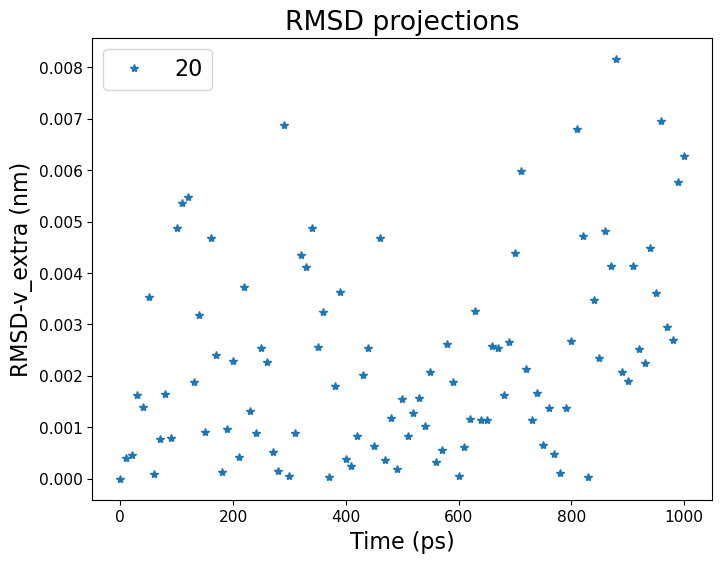

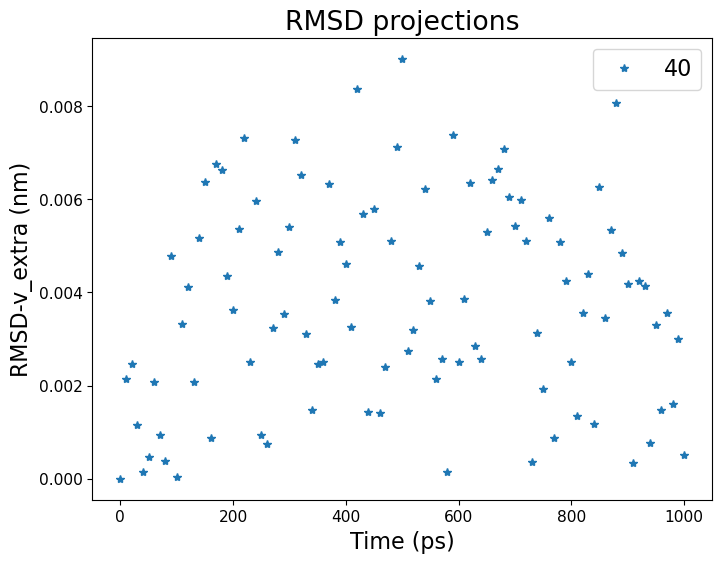

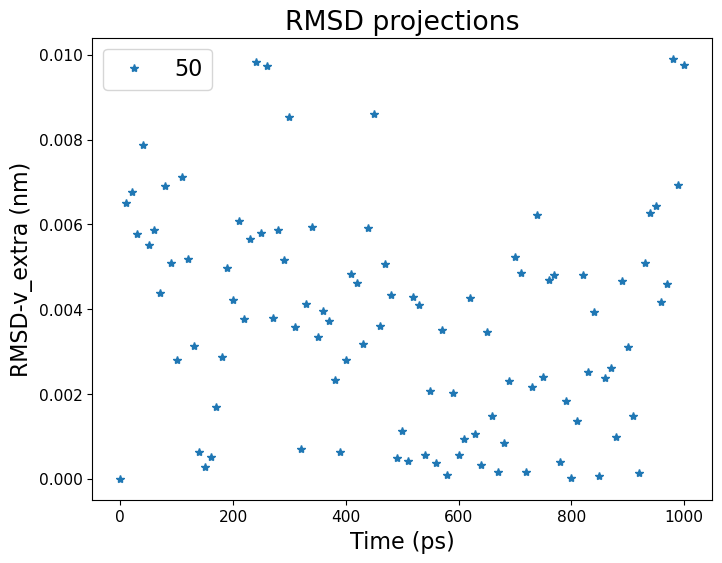

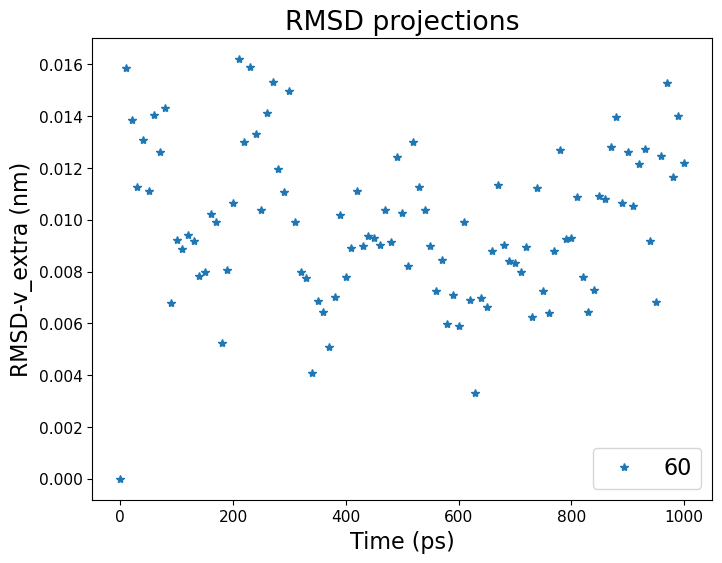

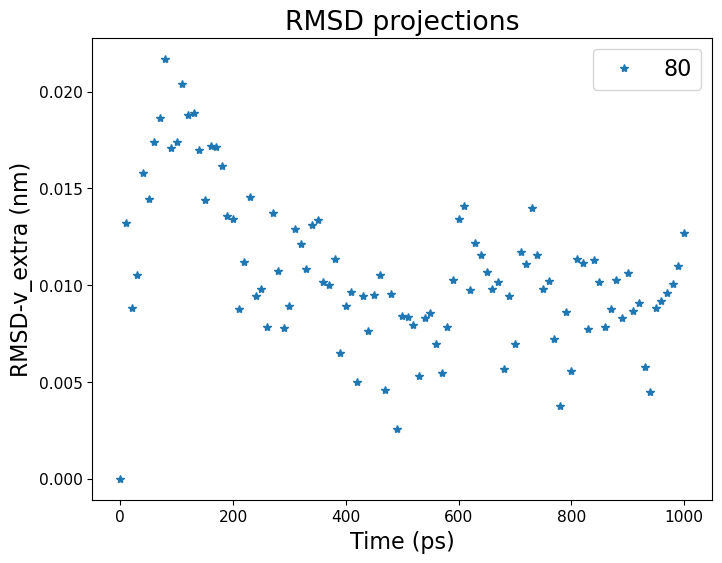

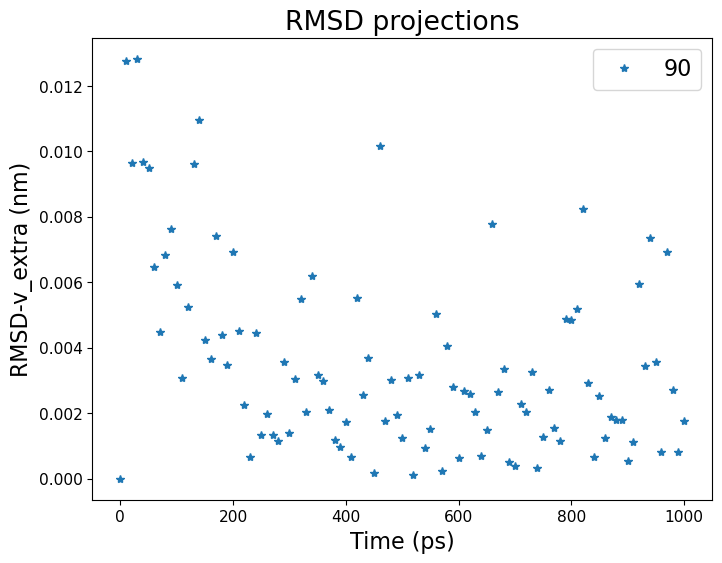

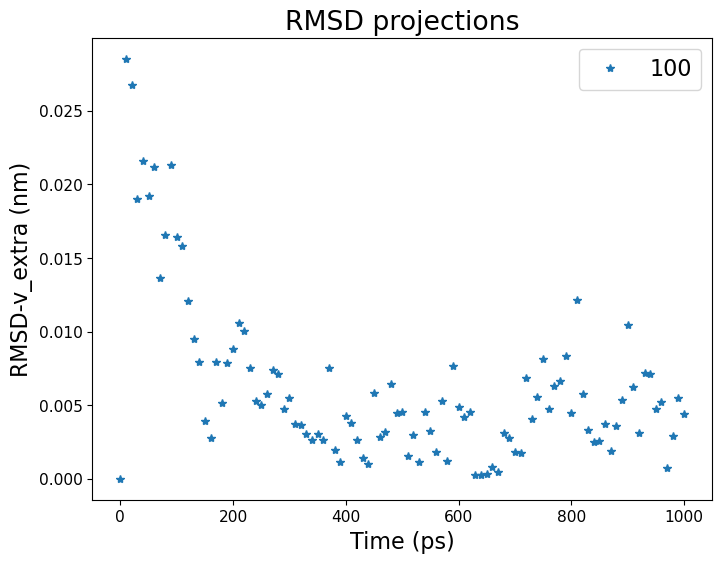

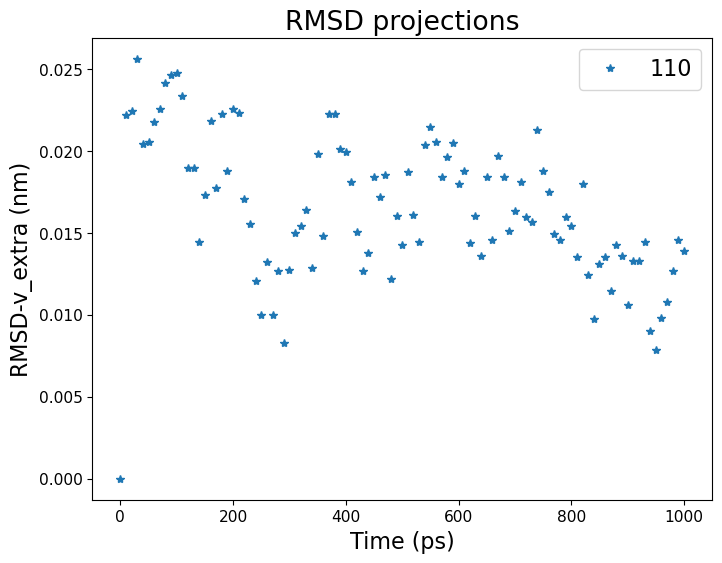

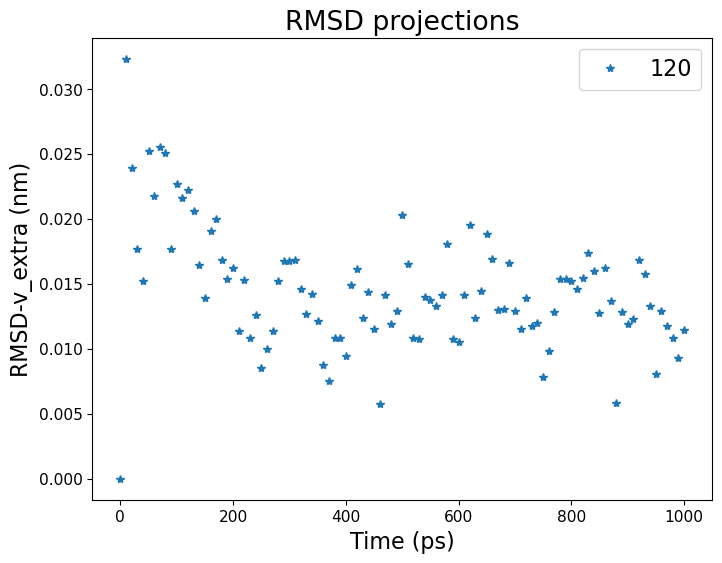

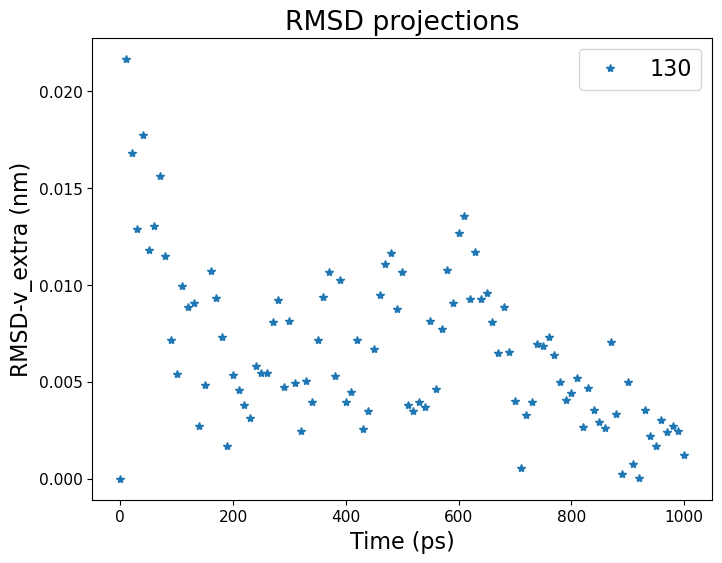

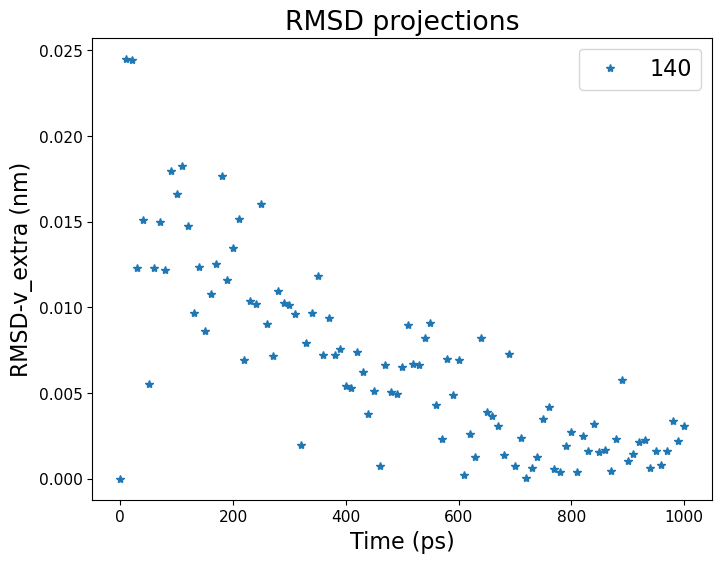

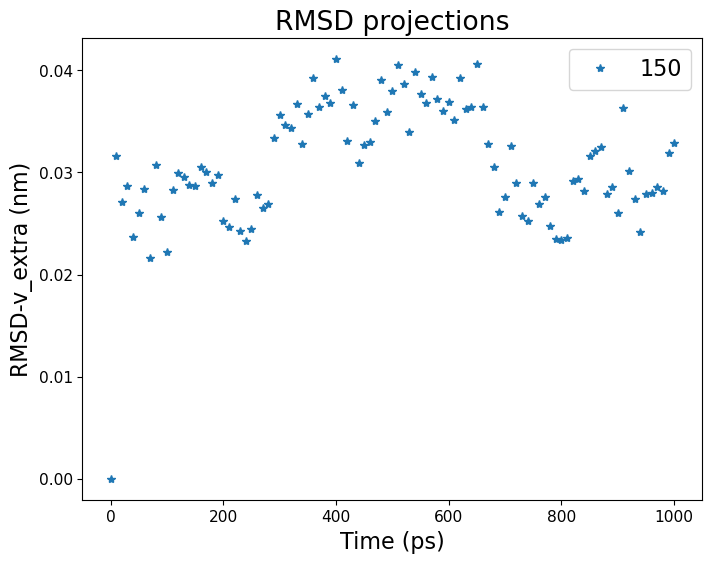

In [60]:
delT = [10, 20, 30, 40, 50, 60, 70, 75, 80, 90, 100, 110, 120, 130, 140, 150]
prmsd = []
time = [i*10 for i in range(101)]
for k in range(len(delT)):
    pdb_mdenm = file_dir+"withlambda_{}_delT/pdb_mdenm.pdb".format(delT[k])
    xtc_mdenm = file_dir+"withlambda_{}_delT/xtc_mdenm.xtc".format(delT[k])
    pdb_ref = file_dir+"pdb_ref.pdb"
    z_v = [residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, '(chainID A or chainID B) and name CA', Um, delT[k])]
    z_v = z_v[0]
    z_v = [i*0.1 for i in (z_v)]
    prmsd.append(z_v)
    plt.figure(figsize=(8,6))
    plt.rcParams['font.size'] = '16'
    plt.plot(time, z_v, '*')
    plt.title('RMSD projections')
    plt.xlabel('Time (ps)')
    plt.ylabel('RMSD-v_extra (nm)')
    plt.legend([str(delT[k])])

In [61]:
delT = [10, 20, 30, 40, 50, 60, 70, 75, 80, 90, 100, 110, 120, 130, 140, 150]
time = [i*10 for i in range(101)]
fig, ax = plt.subplots()
for k in range(len(delT)): 
    ax.plot(time, prmsd[k], label = 'delT = {}'.format(str(delT[k])), linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 3, prop={'size':7})
    ax.set_xlabel('Time (ps)', fontsize = 10)
    ax.set_ylabel('RMSD-v_extra (nm)', fontsize = 10)
#    ax.set_ylim(0, 0.09)
    ax.set_title('RMSD Projections', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
plt.show()

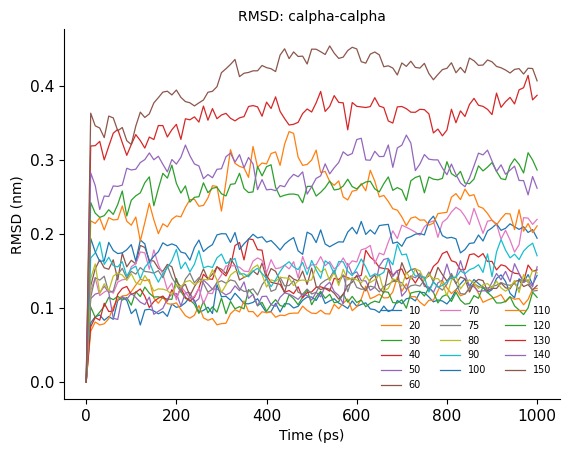

In [62]:
delT = [10, 20, 30, 40, 50, 60, 70, 75, 80, 90, 100, 110, 120, 130, 140, 150]
rmsd = []
fig, ax = plt.subplots()
for k in range(len(delT)):
    filename = file_dir+"withlambda_{}_delT/rmsd_calpha_calpha.xvg".format(delT[k])
    rmsd_value = np.genfromtxt(filename, skip_header = 18)
    rmsd.append(rmsd_value[:, 1])
    ax.plot(rmsd_value[:, 0], rmsd_value[:, 1], label = str(delT[k]), linewidth = 0.9)
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.set_xlabel("Time (ps)", fontsize = 10)
ax.set_ylabel("RMSD (nm)", fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("RMSD: calpha-calpha", fontsize = 10)
plt.legend(frameon = False, loc='lower right', ncol = 3, prop={'size':7})

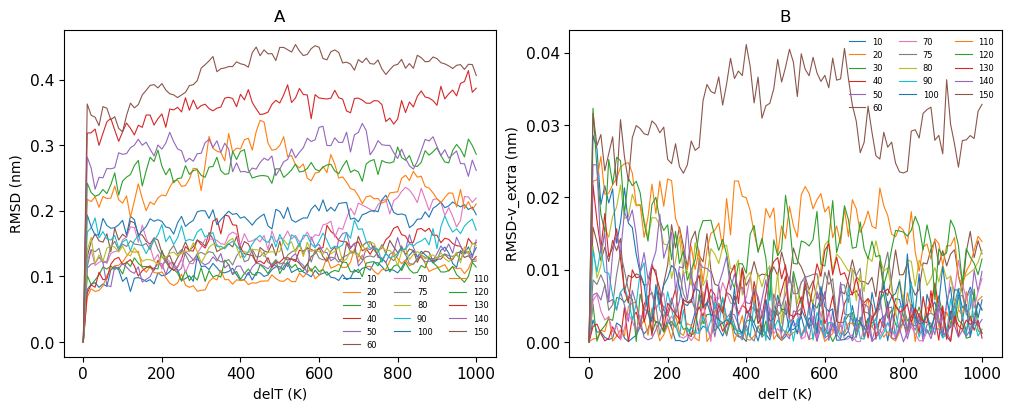

In [63]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), layout='constrained')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

for k in range(len(delT)):
    axes[0].plot(time, rmsd[k], label = str(delT[k]), linewidth = 0.8)
    axes[0].set_xlabel("delT (K)", fontsize = 10)
    axes[0].set_ylabel("RMSD (nm)", fontsize = 10)
    axes[0].set_title("A", fontsize = 12)
    axes[0].legend(frameon = False, loc ="lower right", ncol = 3, prop={'size':6})
    axes[1].plot(time, prmsd[k], label = str(delT[k]), linewidth = 0.8)
    axes[1].set_xlabel("delT (K)", fontsize = 10)
    axes[1].set_ylabel("RMSD-v_extra (nm)", fontsize = 10)
    axes[1].set_title("B", fontsize = 12)
#    axes[1].set_ylim(0, 0.09)
    axes[1].legend(frameon = False, loc ="upper right", ncol = 3, prop={'size':6})

Text(0.5, 1.0, 'B')

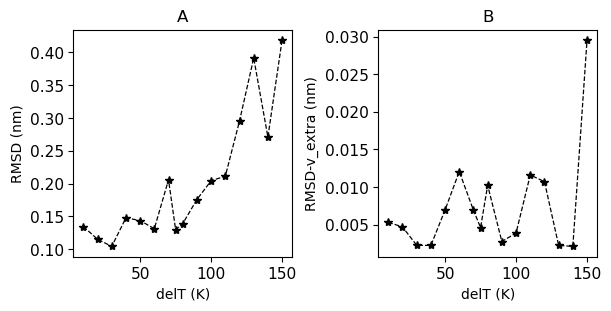

In [64]:
avg_rmsd = []
avg_prmsd = []
for k in range(len(delT)):
    avg_rmsd.append(np.average(rmsd[k][95:]))
    avg_prmsd.append(np.average(prmsd[k][95:]))

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), layout='constrained')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

axes[0].plot(delT, avg_rmsd, '*', linestyle='dashed', color = 'black', linewidth = 0.9)
axes[0].set_xlabel("delT (K)", fontsize = 10)
axes[0].set_ylabel("RMSD (nm)", fontsize = 10)
axes[0].set_title("A", fontsize = 12)
axes[1].plot(delT, avg_prmsd, '*', linestyle='dashed', color = 'black', linewidth = 0.9)
axes[1].set_xlabel("delT (K)", fontsize = 10)
axes[1].set_ylabel("RMSD-v_extra (nm)", fontsize = 10)
axes[1].set_title("B", fontsize = 12)
    
# fig, ax = plt.subplots()
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.plot(delT, avg_rmsd, '*', linestyle='dashed', color = 'grey')
# plt.xlabel("delT (K)", fontsize = 14)
# plt.ylabel("RMSD (nm)", fontsize = 14)
# plt.title("Average RMSD wrt delT", fontsize = 14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# fig, ax = plt.subplots()
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.plot(delT, avg_prmsd, '*', linestyle='dashed', color = 'grey')
# plt.xlabel("delT (K)", fontsize = 14)
# plt.ylabel("RMSD-v_extra (nm)", fontsize = 14)
# plt.title("Average RMSD projections wrt delT", fontsize = 14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)